In [100]:
# Required Libraries
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost catboost shap pyswarms joblib pypandoc
!pip install lightgbm --install-option=--gpu
!pip install torch torchvision torchaudio skorch


Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: --install-option


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, roc_auc_score, average_precision_score,
    precision_score, recall_score, confusion_matrix,
    precision_recall_curve, roc_curve
)
from sklearn.base import clone
from sklearn.neural_network import MLPClassifier

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import shap
from pyswarms.single.global_best import GlobalBestPSO
import joblib
import warnings
import time

warnings.filterwarnings("ignore")

In [3]:
# --- Directories ---
os.makedirs("figures", exist_ok=True)
os.makedirs("results", exist_ok=True)
os.makedirs("models", exist_ok=True)

In [4]:
# --- Load Dataset ---
file_path = "Data.xlsx"
try:
    df = pd.read_excel(file_path)
    print("Dataset loaded successfully.")
    print(f"Initial data shape: {df.shape}")

    # Features & Target
    y = df['Lslide_Sta']
    X = df.drop(columns=['Lslide_Sta'])
    print(f"Features (X) shape: {X.shape}")
    print(f"Target (y) shape: {y.shape}")

except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Please ensure it's in the correct directory.")
    exit() # Exit if data file is not found
except Exception as e:
    print(f"An error occurred during data loading: {e}")
    exit() # Exit on other loading errors

Dataset loaded successfully.
Initial data shape: (500000, 71)
Features (X) shape: (500000, 70)
Target (y) shape: (500000,)


In [5]:
for col in df.columns:
    if any(c in col for c in ['"', "'", "\\", "[", "]", "{", "}", ":", ","]):
        print(f"⚠️ Problematic column: {col}")


In [6]:
df.head()

Lslide_Sta      DEM     Slope     Aspect  Curvature  Plan_Curvature  \
0           0  2160.22  15.48170    5.87998   0.748996        0.538960   
1           0  2170.24   1.81126  286.55600  -1.280630       -1.004690   
2           0  2178.09   1.45306  247.62800   0.277724        0.264852   
3           0  2199.50   9.73645  351.34000   0.282010       -0.211383   
4           0  2182.63   3.81727  316.49900  -0.611572       -0.254104   

   Profile_Curvature  Topographic_Wetness_Index  Stream_Power_Index  \
0          -0.210037                    5.37815             0.27898   
1           0.275939                   12.31690             4.63981   
2          -0.012872                    7.23950            -6.88523   
3          -0.493393                    6.55015             1.27153   
4           0.357469                   13.34530             5.94869   

   Terrain_Ruggedness_Index  ...  Proximity_to_Faults  \
0                  21.57140  ...         53582.194157   
1                  12.39670  ...         53652.663417   
2                   5.07870  ...         53671.504246   
3                  13.49520  ...         55056.529997   
4                   8.43455  ...         54800.811076   

   Proximity_to_Earthquake_Epicenters  Annual_Mean_Temperature  \
0                        28584.906427                   5.6125   
1                        28403.240712                   5.6125   
2                        28318.245267                   5.6125   
3                        28360.508152                   5.3125   
4                        28389.483957                   5.3125   

   Annual_Precipitation  Precipitation_of_Wettest_Month  \
0               747.833                         125.833   
1               748.000                         126.000   
2               748.000                         126.000   
3               753.333                         126.000   
4               753.000                         126.000   

   Precipitation_Seasonality  Precipitation_of_Wettest_Quarter  \
0                    64.8341                           343.667   
1                    64.8831                           344.000   
2                    64.8831                           344.000   
3                    64.3206                           344.000   
4                    64.3402                           344.000   

   Precipitation_of_Driest_Quarter  LULC  Lithology  
0                          36.0000    11        3.0  
1                          36.0000    11        3.0  
2                          36.0000    11        3.0  
3                          36.8333    11        3.0  
4                          37.0000    11        3.0  

[5 rows x 71 columns]

In [7]:
# --- SHAP-RFE Selection ---
def shap_rfe_selection_adaptive(X, y, estimator=None, min_features=15, shap_thresh=0.05, tol=0.001):
    """
    Performs SHAP-RFE feature selection with an adaptive stopping criterion.

    Args:
        X (pd.DataFrame): The feature DataFrame.
        y (pd.Series): The target Series.
        estimator: The model to use for feature importance (default: XGBClassifier).
        min_features (int): The minimum number of features to retain.
        shap_thresh (float): SHAP value threshold below which features are dropped.
        tol (float): Tolerance for performance improvement to continue selection.

    Returns:
        list: Names of the selected features.
    """
    if estimator is None:
        estimator = XGBClassifier(
            tree_method='gpu_hist',
            predictor='gpu_predictor',
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42
        )

    features = list(X.columns)
    X_curr = X.copy()
    best_score = -np.inf # Initialize with a very low score
    best_features = features.copy()

    print(f"Starting SHAP-RFE with {len(features)} initial features. Minimum features: {min_features}")
    while len(features) > min_features:
        model = clone(estimator)
        model.fit(X_curr, y)
        score = model.score(X_curr, y) # Using training score for internal RFE logic

        if score > best_score + tol:
            best_score = score
            best_features = features.copy()
            # print(f"  Current score: {score:.4f}, Best score updated. Features: {len(best_features)}")
        # else:
            # print(f"  Current score: {score:.4f}, no significant improvement detected.")

        # Sample for SHAP to speed up computation
        sample_size = min(500, len(X_curr))
        X_sample = X_curr.sample(sample_size, random_state=42)

        explainer = shap.TreeExplainer(model, approximate=True)
        shap_values = explainer.shap_values(X_sample)
        shap_values = shap_values[1] if isinstance(shap_values, list) else shap_values # For binary classification
        mean_shap = np.abs(shap_values).mean(axis=0)

        # Create a list of (feature, mean_shap_value) tuples and sort them by SHAP value
        feature_shap_pairs = sorted(zip(features, mean_shap), key=lambda x: x[1])
        
        # Identify features below threshold
        below_thresh_candidates = [f for f, val in feature_shap_pairs if val < shap_thresh]
        
        if not below_thresh_candidates: # No features below threshold, remove the single least important
            if len(features) > min_features:
                feature_to_remove = feature_shap_pairs[0][0]
                features.remove(feature_to_remove)
                X_curr = X_curr.drop(columns=[feature_to_remove])
                # print(f"  Removing least important feature: '{feature_to_remove}'. Features remaining: {len(features)}")
            else:
                break # Cannot remove more features if at or below min_features
        else:
            # Determine which features to actually remove to respect min_features
            features_to_remove = []
            for f_cand in below_thresh_candidates:
                if len(features) - len(features_to_remove) - 1 >= min_features:
                    features_to_remove.append(f_cand)
                else:
                    break # Stop if removing next would go below min_features
            
            if not features_to_remove and len(features) > min_features: # If no candidates to remove that maintain min_features, remove the single least important
                feature_to_remove = feature_shap_pairs[0][0]
                if len(features) - 1 >= min_features:
                    features_to_remove.append(feature_to_remove)


            if features_to_remove:
                features = [f for f in features if f not in features_to_remove]
                X_curr = X_curr[features]
                # print(f"  Removed {len(features_to_remove)} features. Features remaining: {len(features)}")
            else:
                break # No features could be removed while maintaining constraints

    print(f"SHAP-RFE completed. Selected {len(best_features)} features.")
    return best_features


# --- Deep Swarm Selection ---
def deep_swarm_selection_adaptive(X, y, num_particles=5, n_iterations=5, min_features=15, feature_penalty=1.0):
    """
    Performs feature selection using Deep Swarm Optimization (PSO).

    Args:
        X (pd.DataFrame): The feature DataFrame.
        y (pd.Series): The target Series.
        num_particles (int): Number of particles in PSO.
        n_iterations (int): Number of iterations for PSO.
        min_features (int): Minimum number of features to select.
        feature_penalty (float): Penalty coefficient for more features.

    Returns:
        list: Names of the selected features.
    """
    # Sample data for faster PSO iterations
    X_sample = X.sample(n=min(500, len(X)), random_state=42)
    y_sample = y.loc[X_sample.index]
    n_features = X_sample.shape[1]

    # Initialize with all features selected as the best mask as a fallback
    best_mask = np.ones(n_features, dtype=bool)
    # Calculate initial best_score based on all features to provide a starting point for comparison
    clf_initial = MLPClassifier(hidden_layer_sizes=(64,), max_iter=200, random_state=42, activation='relu', solver='adam') 
    try:
        clf_initial.fit(X_sample, y_sample)
        initial_score = clf_initial.score(X_sample, y_sample)
        best_score = initial_score - feature_penalty * (n_features / n_features) # Penalize full set too
    except Exception as e:
        print(f"Warning: Initial MLP training failed: {e}. Setting best_score to -inf.")
        best_score = -np.inf

    print(f"Starting Deep Swarm Selection with {n_features} initial features. Min features: {min_features}")

    def objective_function(particles):
        nonlocal best_score, best_mask
        scores = []
        for particle in particles:
            mask = particle > 0.5  # Convert particle position to a binary mask
            n_selected = mask.sum()
            
            if n_selected < min_features:
                scores.append(1e6)  # A very high cost to strongly discourage insufficient features
                continue
            elif n_selected == 0:
                scores.append(1e6)
                continue

            clf = MLPClassifier(hidden_layer_sizes=(64,), max_iter=200, random_state=42, activation='relu', solver='adam')
            try:
                clf.fit(X_sample.loc[:, mask], y_sample)
                score = clf.score(X_sample.loc[:, mask], y_sample)
                penalized_score = score - feature_penalty * (n_selected / n_features)
            except ValueError as e:
                # print(f"Warning during MLP training for particle: {e}. Assigning high penalty.")
                penalized_score = -1e6 # High penalty for invalid feature sets
            
            if penalized_score > best_score:
                best_score = penalized_score
                best_mask = mask.copy()
            
            scores.append(-penalized_score)  # PSO minimizes this cost
        return np.array(scores)

    optimizer = GlobalBestPSO(
        n_particles=num_particles,
        dimensions=n_features,
        options={'c1': 0.5, 'c2': 0.3, 'w': 0.9},
        bounds=(np.zeros(n_features), np.ones(n_features)) # Define bounds for particle positions
    )
    
    cost, pos = optimizer.optimize(objective_function, iters=n_iterations)
    
    # Ensure the final mask adheres to min_features.
    # If the best_mask from PSO is too sparse, try to recover or use the initial set.
    if best_mask.sum() < min_features:
        print(f"Deep Swarm's final best mask ({best_mask.sum()} features) is below min_features ({min_features}).")
        # Attempt to get 'min_features' most "selected" features from the final position 'pos'
        sorted_indices = np.argsort(pos)[::-1] # Sort in descending order of 'selection probability'
        fallback_mask = np.zeros(n_features, dtype=bool)
        fallback_mask[sorted_indices[:min_features]] = True
        
        if fallback_mask.sum() >= min_features:
            final_selected_features = list(X_sample.columns[fallback_mask])
            print(f"  Using fallback: selected {len(final_selected_features)} features based on PSO positions.")
        else: # If even the fallback fails (e.g., n_features < min_features), return all original features
            final_selected_features = list(X.columns)
            print(f"  Fallback failed or not enough features. Returning all {len(final_selected_features)} original features.")
    else:
        final_selected_features = list(X_sample.columns[best_mask])

    print(f"Deep Swarm Selection completed. Selected {len(final_selected_features)} features.")
    return final_selected_features

In [8]:
# --- 70-30 Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
print(f"Data split into training (X_train: {X_train.shape}, y_train: {y_train.shape}) "\
      f"and testing (X_test: {X_test.shape}, y_test: {y_test.shape}) sets.")

Data split into training (X_train: (350000, 70), y_train: (350000,)) and testing (X_test: (150000, 70), y_test: (150000,)) sets.


In [9]:
# --- GPU Models ---
models = {
    "XGBoost": XGBClassifier(
        use_label_encoder=False, 
        eval_metric='logloss',
        tree_method='gpu_hist', 
        predictor='gpu_predictor',
        random_state=42 # Added for reproducibility
    ),
    "CatBoost": CatBoostClassifier(
        verbose=0, 
        task_type="GPU", 
        devices='0',
        random_state=42 # Added for reproducibility
    ),
    "LightGBM": LGBMClassifier(
        device="gpu",
        random_state=42 # Added for reproducibility
    )
}
print("Machine learning models initialized for GPU training.")

# --- Run Experiments ---
results = []
feature_table = {}

# Feature selection methods
fs_methods = {
    "SHAP_RFE": shap_rfe_selection_adaptive,
    "DeepSwarm": deep_swarm_selection_adaptive
}

print("\nStarting experimental runs...")

# 1. Run without any feature selection (all features)
print("\n--- Phase 1: Training models with NO Feature Selection ---")
for model_name, model in models.items():
    print(f"\nTraining {model_name} on all features...")
    
    current_model = clone(model) # Create a fresh instance of the model for each run
    
    start_time = time.time()
    current_model.fit(X_train, y_train)
    training_time = time.time() - start_time
    print(f"  Training time: {training_time:.2f} seconds.")

    y_pred = current_model.predict(X_test)
    y_prob = current_model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    ap = average_precision_score(y_test, y_prob)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    results.append({
        "FS": "No_FS",
        "Model": model_name,
        "Training_Time_s": training_time,
        "Accuracy": acc,
        "ROC_AUC": roc_auc,
        "AP": ap,
        "Precision": precision,
        "Recall": recall,
        "Conf_Matrix": cm.tolist()
    })
    print(f"  Metrics: Accuracy={acc:.4f}, ROC_AUC={roc_auc:.4f}, AP={ap:.4f}")

    # Save model
    model_path = f"models/No_FS_{model_name.replace(' ', '_')}.pkl"
    joblib.dump((current_model, X_train.columns.tolist()), model_path)
    print(f"  Model saved to {model_path}")

    # Plot ROC
    plt.figure(figsize=(8, 6))
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--', color='gray', label='Random Classifier')
    sns.lineplot(x=fpr, y=tpr, label=f'{model_name} (AUC = {roc_auc:.2f})', color='darkorange')
    plt.title(f'ROC Curve - No FS + {model_name}', fontsize=14)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.savefig(f"figures/ROC_No_FS_{model_name.replace(' ', '_')}.png")
    plt.close()
    print(f"  ROC curve saved to figures/ROC_No_FS_{model_name.replace(' ', '_')}.png")

    # Plot PR
    plt.figure(figsize=(8, 6))
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob)
    sns.lineplot(x=recall_curve, y=precision_curve, label=f'{model_name} (AP = {ap:.2f})', color='skyblue')
    plt.title(f'Precision-Recall Curve - No FS + {model_name}', fontsize=14)
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.savefig(f"figures/PR_No_FS_{model_name.replace(' ', '_')}.png")
    plt.close()
    print(f"  PR curve saved to figures/PR_No_FS_{model_name.replace(' ', '_')}.png")

# 2. Run with feature selection
print("\n--- Phase 2: Training models with Feature Selection ---")
for fs_name, fs_func in fs_methods.items():
    print(f"\nSelecting features using {fs_name}...")
    start_fs_time = time.time()
    selected_features = fs_func(X_train, y_train) # Pass X_train for selection based on training data
    fs_time = time.time() - start_fs_time
    feature_table[fs_name] = selected_features
    print(f"  {fs_name} selected {len(selected_features)} features in {fs_time:.2f} seconds.")
    print(f"  Selected features: {selected_features}")

    X_train_sel = X_train[selected_features]
    X_test_sel = X_test[selected_features]

    for model_name, model in models.items():
        print(f"\nTraining {model_name} on {fs_name} features...")
        
        current_model = clone(model) # Create a fresh instance of the model for each run

        start_time = time.time()
        current_model.fit(X_train_sel, y_train)
        training_time = time.time() - start_time
        print(f"  Training time: {training_time:.2f} seconds.")

        y_pred = current_model.predict(X_test_sel)
        y_prob = current_model.predict_proba(X_test_sel)[:, 1]

        acc = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_prob)
        ap = average_precision_score(y_test, y_prob)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)

        results.append({
            "FS": fs_name,
            "Model": model_name,
            "Training_Time_s": training_time,
            "Accuracy": acc,
            "ROC_AUC": roc_auc,
            "AP": ap,
            "Precision": precision,
            "Recall": recall,
            "Conf_Matrix": cm.tolist()
        })
        print(f"  Metrics: Accuracy={acc:.4f}, ROC_AUC={roc_auc:.4f}, AP={ap:.4f}")

        # Save model
        model_path = f"models/{fs_name.replace(' ', '_')}_{model_name.replace(' ', '_')}.pkl"
        joblib.dump((current_model, selected_features), model_path)
        print(f"  Model saved to {model_path}")

        # Plot ROC
        plt.figure(figsize=(8, 6))
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--', color='gray', label='Random Classifier')
        sns.lineplot(x=fpr, y=tpr, label=f'{model_name} (AUC = {roc_auc:.2f})', color='darkorange')
        plt.title(f'ROC Curve - {fs_name} + {model_name}', fontsize=14)
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(fontsize=10)
        plt.tight_layout()
        plt.savefig(f"figures/ROC_{fs_name.replace(' ', '_')}_{model_name.replace(' ', '_')}.png")
        plt.close()
        print(f"  ROC curve saved to figures/ROC_{fs_name.replace(' ', '_')}_{model_name.replace(' ', '_')}.png")

        # Plot PR
        plt.figure(figsize=(8, 6))
        precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob)
        sns.lineplot(x=recall_curve, y=precision_curve, label=f'{model_name} (AP = {ap:.2f})', color='skyblue')
        plt.title(f'Precision-Recall Curve - {fs_name} + {model_name}', fontsize=14)
        plt.xlabel('Recall', fontsize=12)
        plt.ylabel('Precision', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(fontsize=10)
        plt.tight_layout()
        plt.savefig(f"figures/PR_{fs_name.replace(' ', '_')}_{model_name.replace(' ', '_')}.png")
        plt.close()
        print(f"  PR curve saved to figures/PR_{fs_name.replace(' ', '_')}_{model_name.replace(' ', '_')}.png")

print("All experiments completed.")

Machine learning models initialized for GPU training.

Starting experimental runs...

--- Phase 1: Training models with NO Feature Selection ---

Training XGBoost on all features...
  Training time: 1.10 seconds.
  Metrics: Accuracy=0.9785, ROC_AUC=0.9959, AP=0.9944
  Model saved to models/No_FS_XGBoost.pkl
  ROC curve saved to figures/ROC_No_FS_XGBoost.png
  PR curve saved to figures/PR_No_FS_XGBoost.png

Training CatBoost on all features...
  Training time: 7.57 seconds.
  Metrics: Accuracy=0.9644, ROC_AUC=0.9917, AP=0.9891
  Model saved to models/No_FS_CatBoost.pkl
  ROC curve saved to figures/ROC_No_FS_CatBoost.png
  PR curve saved to figures/PR_No_FS_CatBoost.png

Training LightGBM on all features...
[LightGBM] [Info] Number of positive: 175000, number of negative: 175000
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 17373
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 70
[LightGBM] [Info] Using GPU Device: NVI

2025-07-07 10:12:32,655 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Starting Deep Swarm Selection with 70 initial features. Min features: 15


pyswarms.single.global_best: 100%|██████████|5/5, best_cost=-0.28 
2025-07-07 10:12:40,010 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.28, best pos: [0.27755274 0.41264232 0.56970792 0.78601971 0.69749866 0.65389289
 0.67817399 0.980925   0.33636094 0.51602849 0.00596392 0.38694507
 0.64456094 0.80193789 0.68934883 0.94851778 0.61996507 0.99446189
 0.47398264 0.20444539 0.46247207 0.00428676 0.26032748 0.48581025
 0.34230967 0.6370221  0.47700323 0.09558371 0.78162966 0.54340063
 0.91201126 0.51057406 0.28533585 0.25795887 0.7600822  0.58872398
 0.18349938 0.84704066 0.40923806 0.18757299 0.04521536 0.36153702
 0.26647565 0.39667781 0.30788547 0.73845251 0.25057199 0.24501226
 0.43947874 0.78730665 0.48128666 0.40070829 0.59273938 0.88487869
 0.20646127 0.52967531 0.78904413 0.38996615 0.67529915 0.70488245
 0.97755652 0.60513963 0.99915139 0.69126265 0.33288151 0.40267846
 0.47626756 0.39016002 0.65853705 0.54754333]


Deep Swarm Selection completed. Selected 35 features.
  DeepSwarm selected 35 features in 7.79 seconds.
  Selected features: ['Aspect', 'Curvature', 'Plan_Curvature', 'Profile_Curvature', 'Topographic_Wetness_Index', 'Stream_Power_Index', 'Topographic_Position_Index', 'Slope_Length_and_Steepness_factor_(LS-factor)', 'NDVI', 'GNDVI', 'SAVI', 'GRVI', 'OSAVI', 'MSI', 'CI', 'FMI', 'NBR', 'NDBI', 'TCW', 'TCG', 'NDBaI', 'Ratio_VV/VH', 'IDPDD', 'SAR_SAI', 'SAR_SDI', 'POL', 'VH_Coherence', 'Proximity_to_Road', 'Proximity_to_Streams', 'Proximity_to_Faults', 'Proximity_to_Earthquake_Epicenters', 'Annual_Mean_Temperature', 'Annual_Precipitation', 'LULC', 'Lithology']

Training XGBoost on DeepSwarm features...
  Training time: 0.78 seconds.
  Metrics: Accuracy=0.9764, ROC_AUC=0.9953, AP=0.9938
  Model saved to models/DeepSwarm_XGBoost.pkl
  ROC curve saved to figures/ROC_DeepSwarm_XGBoost.png
  PR curve saved to figures/PR_DeepSwarm_XGBoost.png

Training CatBoost on DeepSwarm features...
  Trainin

In [10]:
# --- Save results and feature table ---
results_df = pd.DataFrame(results)
results_df.to_csv("results/experiment_results.csv", index=False)
print("\nExperiment results saved to results/experiment_results.csv")
print("\n--- Experiment Results Summary ---")
print(results_df.round(4))


Experiment results saved to results/experiment_results.csv

--- Experiment Results Summary ---
          FS     Model  Training_Time_s  Accuracy  ROC_AUC      AP  Precision  \
0      No_FS   XGBoost           1.1032    0.9785   0.9959  0.9944     0.9629   
1      No_FS  CatBoost           7.5721    0.9644   0.9917  0.9891     0.9429   
2      No_FS  LightGBM           2.2586    0.9538   0.9884  0.9848     0.9288   
3   SHAP_RFE   XGBoost           0.3974    0.9795   0.9961  0.9949     0.9640   
4   SHAP_RFE  CatBoost           6.4996    0.9660   0.9922  0.9896     0.9445   
5   SHAP_RFE  LightGBM           1.1801    0.9554   0.9891  0.9857     0.9307   
6  DeepSwarm   XGBoost           0.7757    0.9764   0.9953  0.9938     0.9595   
7  DeepSwarm  CatBoost           6.8571    0.9621   0.9909  0.9878     0.9395   
8  DeepSwarm  LightGBM           1.4846    0.9523   0.9884  0.9849     0.9273   

   Recall                     Conf_Matrix  
0  0.9953   [[72121, 2879], [349, 74651]]  
1  0.

In [11]:
# Save Feature Table
feature_table_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in feature_table.items()]))
feature_table_df.to_csv("results/selected_features_table.csv", index=False)
print("\nSelected features table saved to results/selected_features_table.csv")
print("\n--- Selected Features ---")
print(feature_table_df.head())
print("\nPipeline execution complete.")


Selected features table saved to results/selected_features_table.csv

--- Selected Features ---
                      SHAP_RFE                  DeepSwarm
0                          DEM                     Aspect
1                       Aspect                  Curvature
2     Terrain_Ruggedness_Index             Plan_Curvature
3  Topographic_Roughness_Index          Profile_Curvature
4                         ARVI  Topographic_Wetness_Index

Pipeline execution complete.


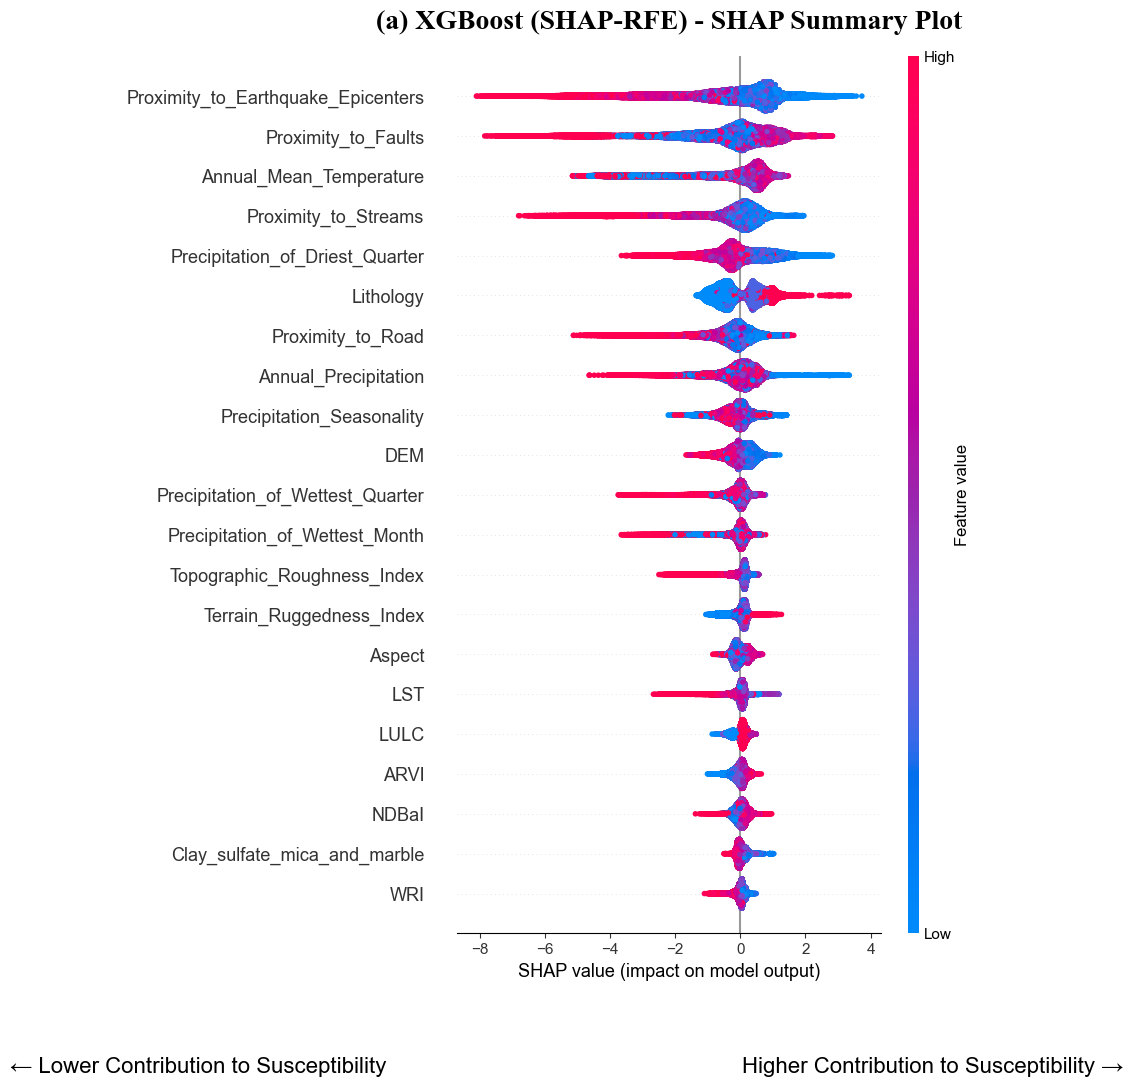

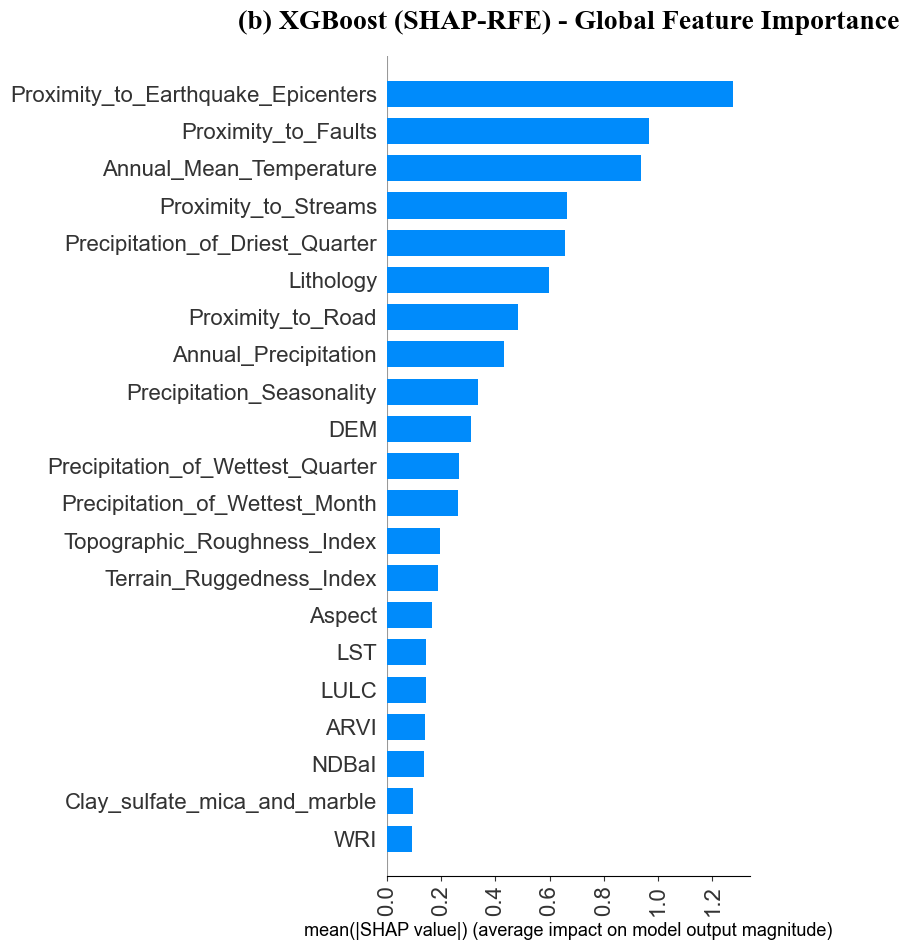

✅ All SHAP summary plots saved successfully.


In [68]:
import shap
import joblib
import matplotlib.pyplot as plt
import numpy as np
import os

# ----------- Configuration ------------
model_path = "models/SHAP_RFE_XGBoost.pkl"
output_folder = "figures"
os.makedirs(output_folder, exist_ok=True)

font = {'family': 'Arial', 'size': 20}
plt.rc('font', **font)

# ----------- Load Model & Data ------------
model, selected_features = joblib.load(model_path)
X_selected = X_test[selected_features]

# ----------- Compute SHAP Values ------------
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_selected)

# ----------- Determine Format ------------
if isinstance(shap_values, list):
    # For classifier: list of arrays per class
    class_indices = [1] if len(shap_values) == 2 else list(range(len(shap_values)))
else:
    # For binary classification or regression: single array
    class_indices = [None]

# ----------- Plot Loop ------------
for class_idx in class_indices:
    shap_class = shap_values if class_idx is None else shap_values[class_idx]
    
    num_features = X_selected.shape[1]
    fig_height = max(6, 0.5 * num_features)

    # --- DOT PLOT ---
    fig = plt.figure(figsize=(18, fig_height))  # Wider and taller if needed
    
    # SHAP handles layout better if you don’t use tight_layout before or during plotting
    shap.summary_plot(
        shap_class,
        features=X_selected,
        plot_type="dot",
        feature_names=selected_features,
        show=False,
        max_display=num_features
    )
    
    # Now manually adjust spacing if needed
    plt.title(f"(a) XGBoost (SHAP-RFE) - SHAP Summary Plot",
              fontsize=20, fontweight='bold', fontfamily='Times New Roman', pad=20)
    
    # You can try increasing fig height if you have many features:
    # fig.set_size_inches(18, 1.2 * num_features)
    
    plt.gcf().subplots_adjust(left=0.3)  # Makes space for long feature names
    plt.text(0.05, -4.5, 'Higher Contribution to Susceptibility \u2192', fontsize=16, fontweight='ultralight')
    plt.text(-22.43, -4.5, '\u2190 Lower Contribution to Susceptibility', fontsize=16, fontweight='ultralight')
    
    fig.savefig(f"{output_folder}/SHAP_summary_dot_SHAPFS_XGBoost.jpg", dpi=300, bbox_inches='tight')
    plt.show()


    # --- BAR PLOT ---
    fig = plt.figure(figsize=(18, fig_height))
    shap.summary_plot(
        shap_class,
        features=X_selected,
        plot_type="bar",
        feature_names=selected_features,
        show=False,
        max_display=num_features
    )
    plt.xticks(rotation=90, fontsize=16)
    plt.yticks(fontsize=16)
    plt.title(f"(b) XGBoost (SHAP-RFE) - Global Feature Importance",
              fontsize=20, fontweight='bold', fontfamily='Times New Roman', pad=20)
    plt.tight_layout()
    fig.savefig(f"{output_folder}/SHAP_summary_bar_SHAPFS_XGBoost.jpg", dpi=300, bbox_inches='tight')
    plt.show()

print("✅ All SHAP summary plots saved successfully.")


In [54]:
shap_values.shape

(150000, 21)

In [69]:
# Calculate mean(|SHAP|) per feature
mean_abs_shap = np.abs(shap_values).mean(axis=0)
# Convert to percentage
percent_shap = 100 * mean_abs_shap / mean_abs_shap.sum()

# Create DataFrame
shap_percent_df = pd.DataFrame({
    'Feature': X_selected.columns,
    'SHAP_Importance_%': percent_shap
}).sort_values(by='SHAP_Importance_%', ascending=False)

# Show results
print(shap_percent_df)

# Optional: save
shap_percent_df.to_csv("results/shap_percentual_importance_SHAPFS_XGBoost.csv", index=False)

                               Feature  SHAP_Importance_%
12  Proximity_to_Earthquake_Epicenters          15.010248
11                 Proximity_to_Faults          11.368858
13             Annual_Mean_Temperature          11.044065
10                Proximity_to_Streams           7.833433
18     Precipitation_of_Driest_Quarter           7.723330
20                           Lithology           7.046311
9                    Proximity_to_Road           5.686596
14                Annual_Precipitation           5.083720
16           Precipitation_Seasonality           3.936226
0                                  DEM           3.637515
17    Precipitation_of_Wettest_Quarter           3.135570
15      Precipitation_of_Wettest_Month           3.080300
3          Topographic_Roughness_Index           2.293277
2             Terrain_Ruggedness_Index           2.202471
1                               Aspect           1.951971
6                                  LST           1.719378
19            

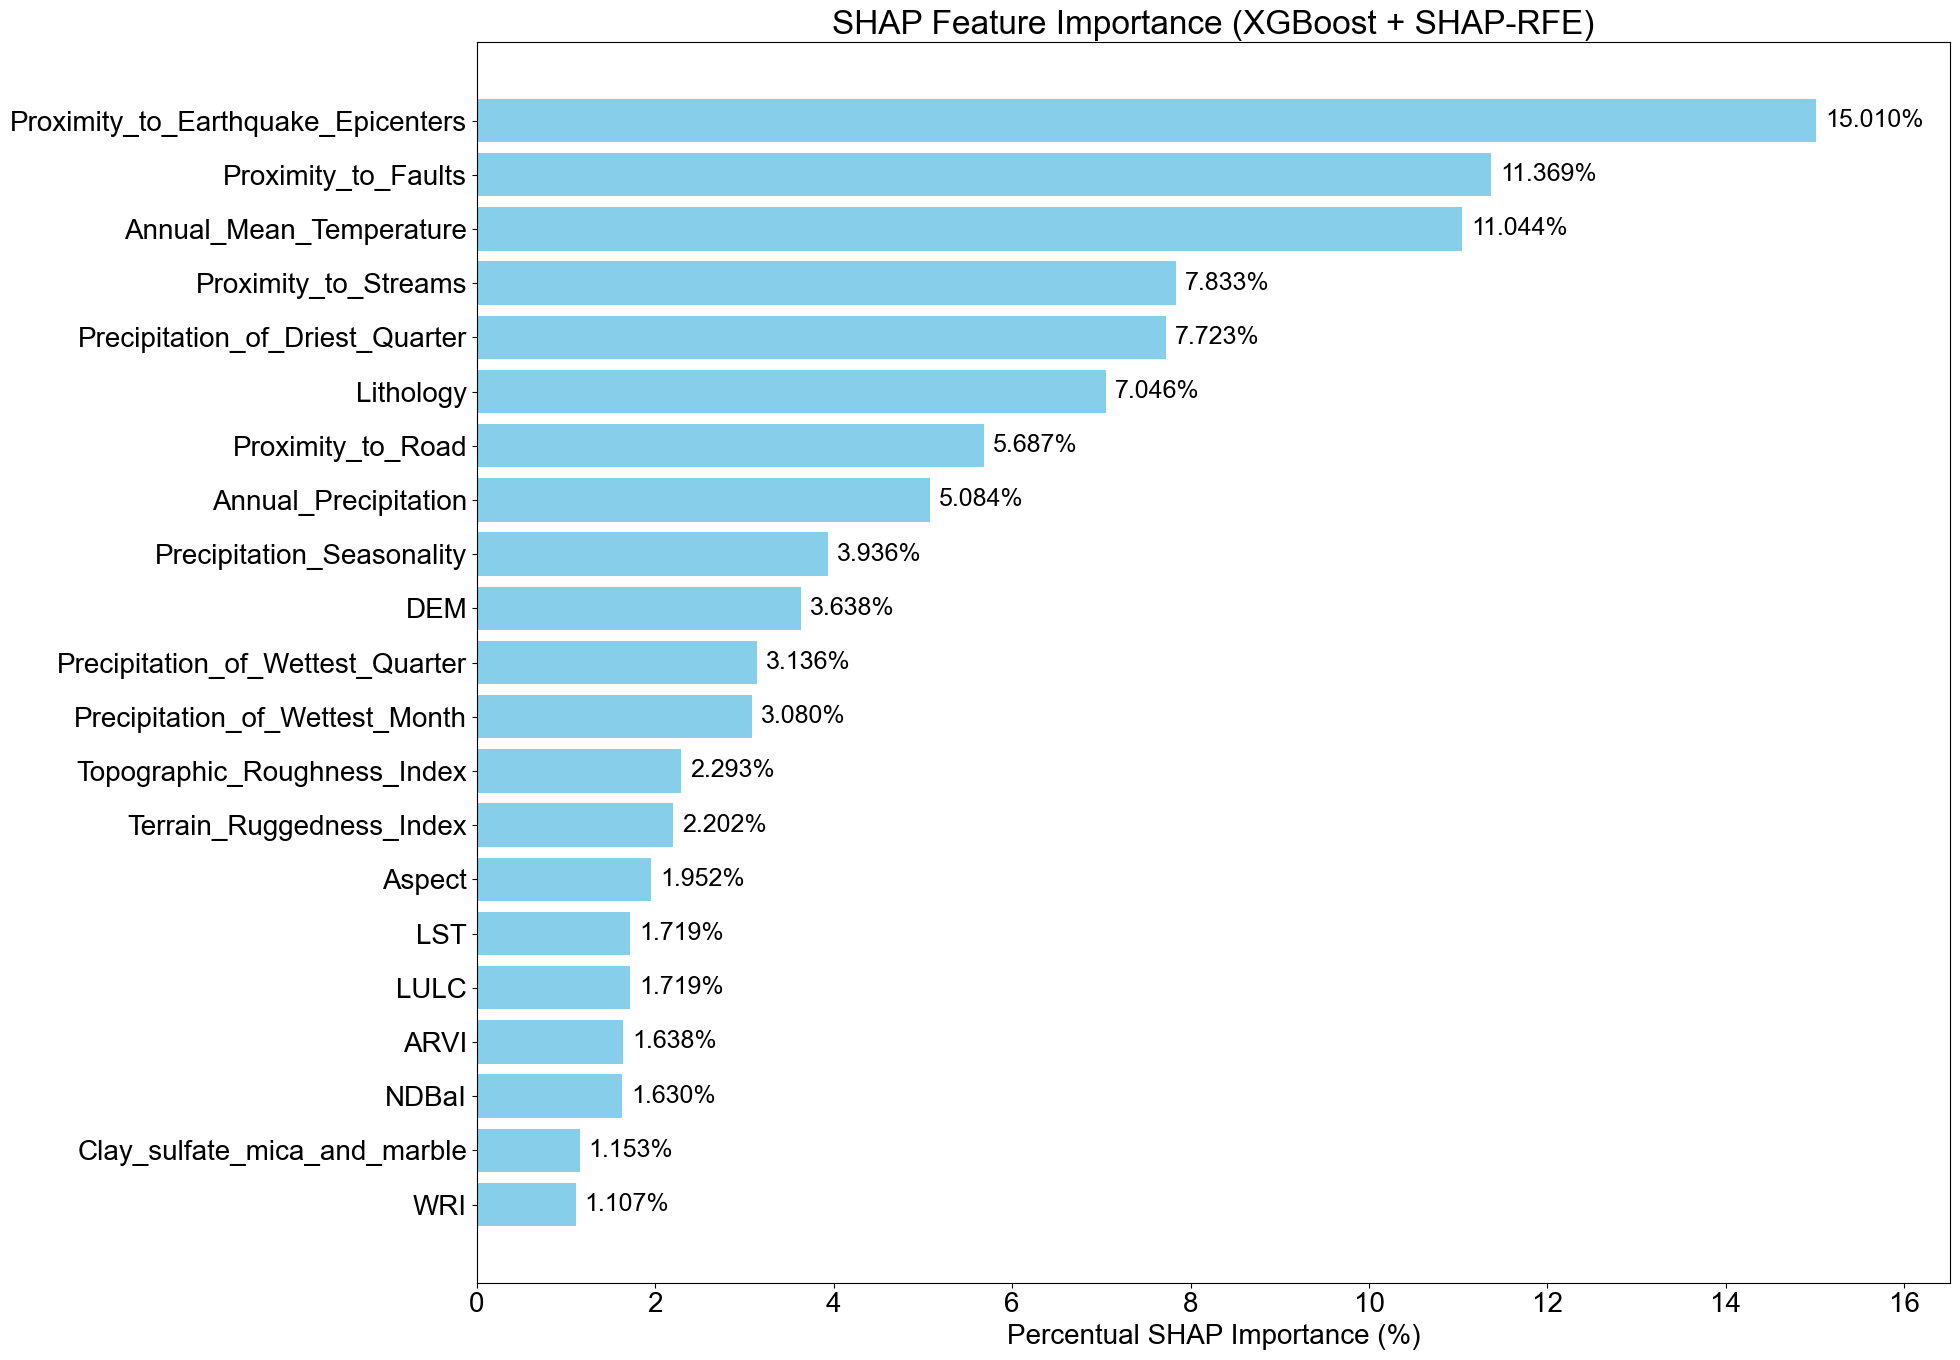

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 14))
bars = plt.barh(shap_percent_df['Feature'], shap_percent_df['SHAP_Importance_%'], color='skyblue')

# Add percentage text next to each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.1,
             bar.get_y() + bar.get_height() / 2,
             f"{width:.3f}%",
             va='center', ha='left', fontsize=18)

# Add padding to avoid overlap with figure edge
max_width = shap_percent_df['SHAP_Importance_%'].max()
plt.xlim(0, max_width * 1.1)

plt.xlabel("Percentual SHAP Importance (%)")
plt.title("SHAP Feature Importance (XGBoost + SHAP-RFE)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("figures/SHAP_percentual_importance_bar_SHAPFS_XGBoost.png")
plt.show()


In [71]:
total_percent = shap_percent_df["SHAP_Importance_%"].sum()
print(f"Total SHAP Percentage: {total_percent:.6f}%")


Total SHAP Percentage: 99.999985%


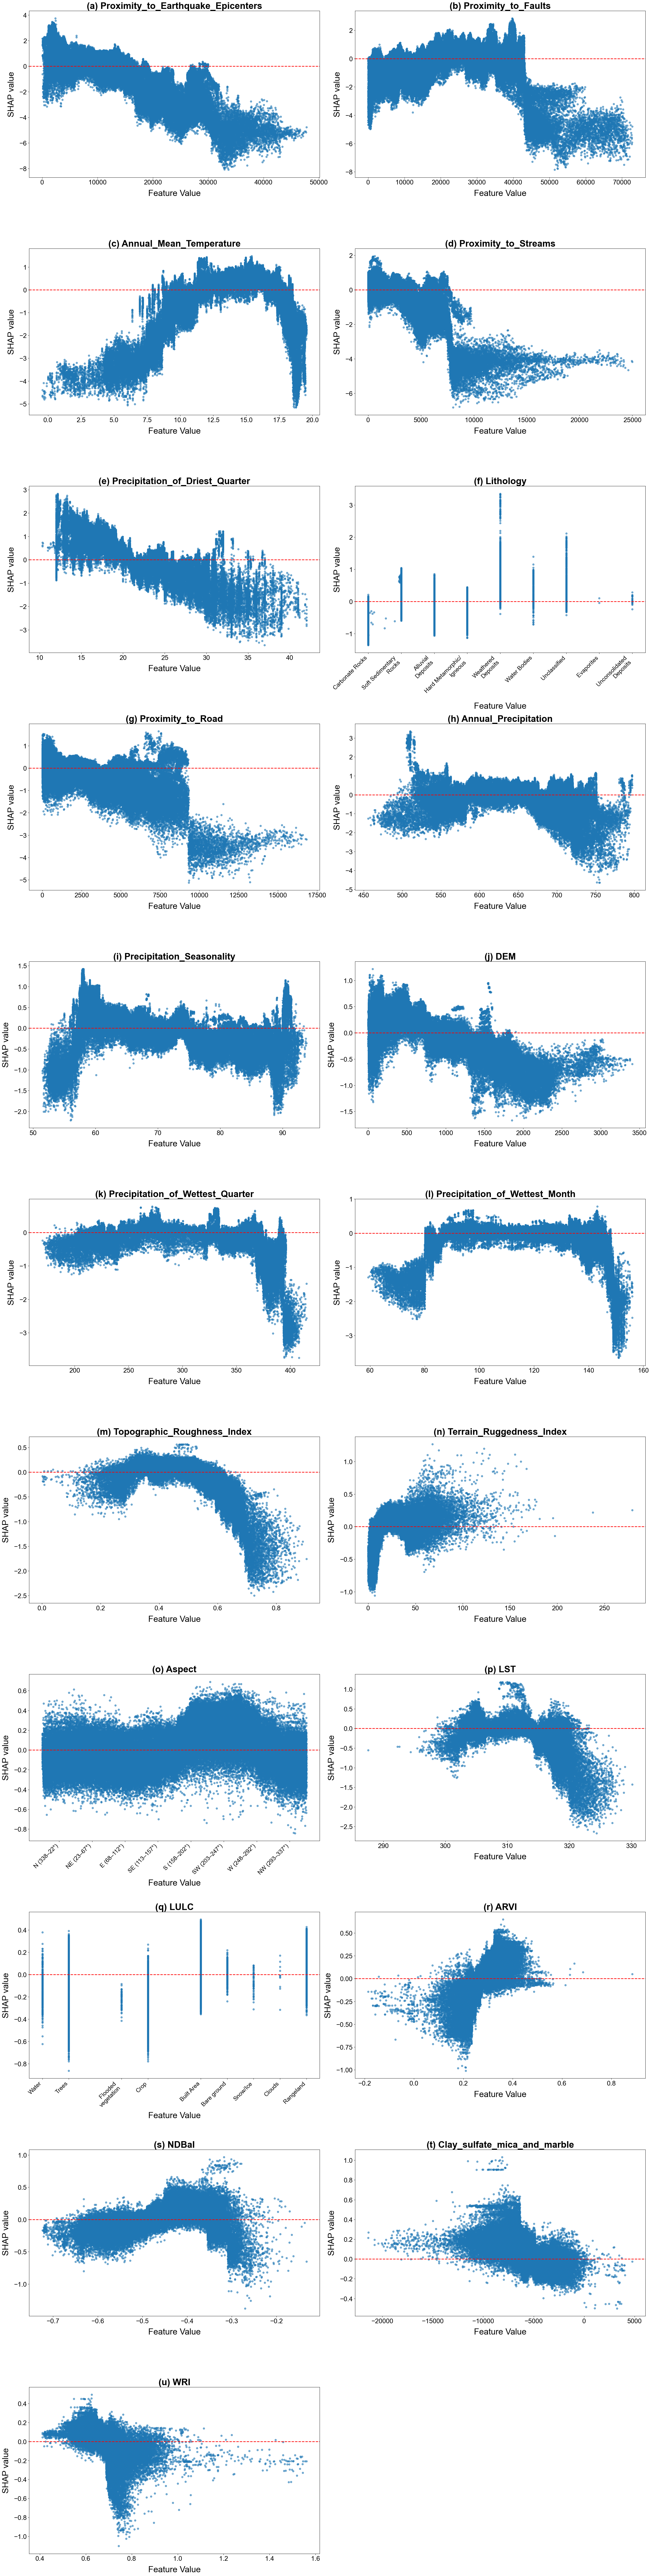

In [92]:
import shap
import joblib
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import string

# ----------- Configuration ------------
model_path = "models/SHAP_RFE_XGBoost.pkl"
output_folder = "figures"
os.makedirs(output_folder, exist_ok=True)

font = {'family': 'Arial', 'size': 14}
plt.rc('font', **font)

# ----------- Load Model & Data ------------
model, selected_features = joblib.load(model_path)
X_selected = X_test[selected_features]

# ----------- Compute SHAP Values ------------
explainer = shap.TreeExplainer(model)
shap_vals_all = explainer.shap_values(X_selected)
shap_values = shap_vals_all[1] if isinstance(shap_vals_all, list) else shap_vals_all

# ----------- Order Features by Importance ------------
mean_abs_shap = np.abs(shap_values).mean(axis=0)
feature_order = np.array(selected_features)[np.argsort(-mean_abs_shap)]

# ----------- Custom Tick Mappings ------------
aspect_ticks = [  22,  67,  112, 157, 202, 247, 292, 337]
aspect_labels = [
    "N (338–22°)",
    "NE (23–67°)",
    "E (68–112°)",
    "SE (113–157°)",
    "S (158–202°)",
    "SW (203–247°)",
    "W (248–292°)",
    "NW (293–337°)"
]

lulc_ticks = [1, 2, 4, 5, 7, 8, 9, 10, 11]
lulc_labels = [
    "Water", "Trees", "Flooded\nvegetation", "Crop",
    "Built Area", "Bare ground", "Snow/Ice",
    "Clouds", "Rangeland"
]

litho_ticks = list(range(1, 10))
litho_labels = [
    "Carbonate Rocks", "Soft Sedimentary\nRocks", "Alluvial\nDeposits",
    "Hard Metamorphic/\nIgneous", "Weathered\nDeposits",
    "Water Bodies", "Unclassified", "Evaporites",
    "Unconsolidated\nDeposits"
]

# ----------- Plotting ------------
n = len(feature_order)
cols = 2
rows = math.ceil(n/cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*14, rows*10), squeeze=False)

for i, feat in enumerate(feature_order):
    r, c = divmod(i, cols)
    ax = axes[r][c]

    # Title
    ax.set_title(f"({string.ascii_lowercase[i]}) {feat}", 
                 fontsize=28, fontweight='bold')

    # Scatter
    vals = X_selected[feat].values
    shaps = shap_values[:, X_selected.columns.get_loc(feat)]
    ax.scatter(vals, shaps, alpha=0.6, s=30)

    # Zero line
    ax.axhline(0, linestyle='--', color='red', linewidth=2)

    # Axis labels
    ax.set_xlabel("Feature Value", fontsize=26, labelpad=12)
    ax.set_ylabel("SHAP value", fontsize=26, labelpad=12)

    # Tick params
    ax.tick_params(axis='both', which='major', labelsize=20)

    # Custom ticks
    key = feat.lower()
    if key == "aspect":
        ax.set_xticks(aspect_ticks)
        ax.set_xticklabels(aspect_labels, rotation=45, ha='right', fontsize=18)
    elif key == "lulc":
        ax.set_xticks(lulc_ticks)
        ax.set_xticklabels(lulc_labels, rotation=45, ha='right', fontsize=18)
    elif key == "lithology":
        ax.set_xticks(litho_ticks)
        ax.set_xticklabels(litho_labels, rotation=45, ha='right', fontsize=18)

# Remove unused axes
for idx in range(n, rows*cols):
    r, c = divmod(idx, cols)
    fig.delaxes(axes[r][c])

plt.tight_layout()
plt.savefig(f"figures/SHAP_dependence_subplots_XGBoost_SHAPRFE.jpg", dpi=300, bbox_inches='tight')
plt.show()

In [103]:
import os
import joblib
import shap
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr
from IPython.display import display

# ─── INTERPRETATION ───────────────────────────────────────────────────────────
records = []
for idx, feat in enumerate(selected_features):
    vals  = X_selected[feat].values
    shaps = shap_values[:, idx]
    
    # basic stats
    pct_pos   = (shaps > 0).mean() * 100
    mean_shap = shaps.mean()
    pearson_r, _  = pearsonr(vals, shaps)
    spearman_r, _ = spearmanr(vals, shaps)
    
    # bin‐wise trend
    bins      = pd.qcut(vals, n_bins, duplicates="drop")
    bin_means = pd.DataFrame({'shap': shaps, 'val': vals}).groupby(bins)['shap'].mean()
    if bin_means.is_monotonic_increasing:
        trend = "increasing"
    elif bin_means.is_monotonic_decreasing:
        trend = "decreasing"
    else:
        trend = "non-monotonic"
    
    records.append({
        "Feature":         feat,
        "% Positive SHAP": f"{pct_pos:.1f}%",
        "Mean SHAP":       f"{mean_shap:.3f}",
        "Pearson r":       f"{pearson_r:.2f}",
        "Spearman ρ":      f"{spearman_r:.2f}",
        "Trend":           trend,
        "Interpretation": (
            f"{feat}: {pct_pos:.1f}% of cases ↑ risk; "
            f"mean SHAP={mean_shap:.3f}; "
            f"Pearson r={pearson_r:.2f}, Spearman ρ={spearman_r:.2f}; "
            f"{trend} across quartiles."
        )
    })

df_interp = pd.DataFrame(records)
# sort by absolute impact
df_interp["abs_mean"] = df_interp["Mean SHAP"].astype(float).abs()
df_interp = df_interp.sort_values("abs_mean", ascending=False).drop(columns="abs_mean")

# ─── DISPLAY ─────────────────────────────────────────────────────────────────
display(df_interp)
pd.set_option('display.max_colwidth', None)

# Display the Feature and full Interpretation text
display(df_interp[["Feature", "Interpretation"]])

df_interp.to_csv("results/SHAP_interpretation.csv", index=False)




Feature % Positive SHAP Mean SHAP Pearson r  \
12  Proximity_to_Earthquake_Epicenters           52.3%    -0.422     -0.83   
13             Annual_Mean_Temperature           60.5%    -0.336      0.32   
11                 Proximity_to_Faults           49.9%    -0.312     -0.15   
10                Proximity_to_Streams           52.2%    -0.302     -0.82   
9                    Proximity_to_Road           33.9%    -0.288     -0.68   
17    Precipitation_of_Wettest_Quarter           41.6%    -0.159     -0.29   
15      Precipitation_of_Wettest_Month           51.0%    -0.150      0.01   
16           Precipitation_Seasonality           40.5%    -0.112     -0.27   
14                Annual_Precipitation           53.5%    -0.079     -0.20   
18     Precipitation_of_Driest_Quarter           42.6%    -0.049     -0.80   
6                                  LST           60.1%    -0.042     -0.52   
2             Terrain_Ruggedness_Index           62.3%    -0.032      0.46   
8         Clay_sulfate_mica_and_marble           51.4%     0.030     -0.66   
20                           Lithology           45.1%    -0.020      0.74   
7                                NDBaI           57.1%     0.020      0.50   
3          Topographic_Roughness_Index           68.1%    -0.020     -0.63   
0                                  DEM           52.0%    -0.011     -0.75   
1                               Aspect           46.4%     0.009      0.36   
4                                 ARVI           53.5%    -0.009      0.77   
19                                LULC           65.3%     0.008      0.70   
5                                  WRI           57.9%    -0.002     -0.60   

   Spearman ρ          Trend  \
12      -0.77     decreasing   
13       0.20  non-monotonic   
11       0.23  non-monotonic   
10      -0.68     decreasing   
9       -0.59     decreasing   
17      -0.31  non-monotonic   
15      -0.09  non-monotonic   
16      -0.39     decreasing   
14      -0.14  non-monotonic   
18      -0.76     decreasing   
6       -0.46  non-monotonic   
2        0.54  non-monotonic   
8       -0.71     decreasing   
20       0.82     increasing   
7        0.63  non-monotonic   
3       -0.58  non-monotonic   
0       -0.74  non-monotonic   
1        0.41  non-monotonic   
4        0.88     increasing   
19       0.59     increasing   
5       -0.77     decreasing   

                                       Interpretation  
12  Proximity_to_Earthquake_Epicenters: 52.3% of c...  
13  Annual_Mean_Temperature: 60.5% of cases ↑ risk...  
11  Proximity_to_Faults: 49.9% of cases ↑ risk; me...  
10  Proximity_to_Streams: 52.2% of cases ↑ risk; m...  
9   Proximity_to_Road: 33.9% of cases ↑ risk; mean...  
17  Precipitation_of_Wettest_Quarter: 41.6% of cas...  
15  Precipitation_of_Wettest_Month: 51.0% of cases...  
16  Precipitation_Seasonality: 40.5% of cases ↑ ri...  
14  Annual_Precipitation: 53.5% of cases ↑ risk; m...  
18  Precipitation_of_Driest_Quarter: 42.6% of case...  
6   LST: 60.1% of cases ↑ risk; mean SHAP=-0.042; ...  
2   Terrain_Ruggedness_Index: 62.3% of cases ↑ ris...  
8   Clay_sulfate_mica_and_marble: 51.4% of cases ↑...  
20  Lithology: 45.1% of cases ↑ risk; mean SHAP=-0...  
7   NDBaI: 57.1% of cases ↑ risk; mean SHAP=0.020;...  
3   Topographic_Roughness_Index: 68.1% of cases ↑ ...  
0   DEM: 52.0% of cases ↑ risk; mean SHAP=-0.011; ...  
1   Aspect: 46.4% of cases ↑ risk; mean SHAP=0.009...  
4   ARVI: 53.5% of cases ↑ risk; mean SHAP=-0.009;...  
19  LULC: 65.3% of cases ↑ risk; mean SHAP=0.008; ...  
5   WRI: 57.9% of cases ↑ risk; mean SHAP=-0.002; ...

Feature  \
12  Proximity_to_Earthquake_Epicenters   
13             Annual_Mean_Temperature   
11                 Proximity_to_Faults   
10                Proximity_to_Streams   
9                    Proximity_to_Road   
17    Precipitation_of_Wettest_Quarter   
15      Precipitation_of_Wettest_Month   
16           Precipitation_Seasonality   
14                Annual_Precipitation   
18     Precipitation_of_Driest_Quarter   
6                                  LST   
2             Terrain_Ruggedness_Index   
8         Clay_sulfate_mica_and_marble   
20                           Lithology   
7                                NDBaI   
3          Topographic_Roughness_Index   
0                                  DEM   
1                               Aspect   
4                                 ARVI   
19                                LULC   
5                                  WRI   

                                                                                                                                   Interpretation  
12   Proximity_to_Earthquake_Epicenters: 52.3% of cases ↑ risk; mean SHAP=-0.422; Pearson r=-0.83, Spearman ρ=-0.77; decreasing across quartiles.  
13             Annual_Mean_Temperature: 60.5% of cases ↑ risk; mean SHAP=-0.336; Pearson r=0.32, Spearman ρ=0.20; non-monotonic across quartiles.  
11                Proximity_to_Faults: 49.9% of cases ↑ risk; mean SHAP=-0.312; Pearson r=-0.15, Spearman ρ=0.23; non-monotonic across quartiles.  
10                 Proximity_to_Streams: 52.2% of cases ↑ risk; mean SHAP=-0.302; Pearson r=-0.82, Spearman ρ=-0.68; decreasing across quartiles.  
9                     Proximity_to_Road: 33.9% of cases ↑ risk; mean SHAP=-0.288; Pearson r=-0.68, Spearman ρ=-0.59; decreasing across quartiles.  
17  Precipitation_of_Wettest_Quarter: 41.6% of cases ↑ risk; mean SHAP=-0.159; Pearson r=-0.29, Spearman ρ=-0.31; non-monotonic across quartiles.  
15     Precipitation_of_Wettest_Month: 51.0% of cases ↑ risk; mean SHAP=-0.150; Pearson r=0.01, Spearman ρ=-0.09; non-monotonic across quartiles.  
16            Precipitation_Seasonality: 40.5% of cases ↑ risk; mean SHAP=-0.112; Pearson r=-0.27, Spearman ρ=-0.39; decreasing across quartiles.  
14              Annual_Precipitation: 53.5% of cases ↑ risk; mean SHAP=-0.079; Pearson r=-0.20, Spearman ρ=-0.14; non-monotonic across quartiles.  
18      Precipitation_of_Driest_Quarter: 42.6% of cases ↑ risk; mean SHAP=-0.049; Pearson r=-0.80, Spearman ρ=-0.76; decreasing across quartiles.  
6                                LST: 60.1% of cases ↑ risk; mean SHAP=-0.042; Pearson r=-0.52, Spearman ρ=-0.46; non-monotonic across quartiles.  
2             Terrain_Ruggedness_Index: 62.3% of cases ↑ risk; mean SHAP=-0.032; Pearson r=0.46, Spearman ρ=0.54; non-monotonic across quartiles.  
8           Clay_sulfate_mica_and_marble: 51.4% of cases ↑ risk; mean SHAP=0.030; Pearson r=-0.66, Spearman ρ=-0.71; decreasing across quartiles.  
20                              Lithology: 45.1% of cases ↑ risk; mean SHAP=-0.020; Pearson r=0.74, Spearman ρ=0.82; increasing across quartiles.  
7                                 NDBaI: 57.1% of cases ↑ risk; mean SHAP=0.020; Pearson r=0.50, Spearman ρ=0.63; non-monotonic across quartiles.  
3        Topographic_Roughness_Index: 68.1% of cases ↑ risk; mean SHAP=-0.020; Pearson r=-0.63, Spearman ρ=-0.58; non-monotonic across quartiles.  
0                                DEM: 52.0% of cases ↑ risk; mean SHAP=-0.011; Pearson r=-0.75, Spearman ρ=-0.74; non-monotonic across quartiles.  
1                                Aspect: 46.4% of cases ↑ risk; mean SHAP=0.009; Pearson r=0.36, Spearman ρ=0.41; non-monotonic across quartiles.  
4                                    ARVI: 53.5% of cases ↑ risk; mean SHAP=-0.009; Pearson r=0.77, Spearman ρ=0.88; increasing across quartiles.  
19                                    LULC: 65.3% of cases ↑ risk; mean SHAP=0.008; Pearson r=0.70, Spearman ρ=0.59; increasing across quartiles. 

In [106]:
window_fraction  = 0.1  # window width as fraction of total samples
top_k            = 3    # top intervals per feature
# ─── SLIDING WINDOW INTERVAL ANALYSIS ────────────────────────────────────────
results = {}
n_samples = X_selected.shape[0]
window_size = max(1, int(window_fraction * n_samples))

for idx, feat in enumerate(selected_features):
    df = pd.DataFrame({
        'value': X_selected[feat].values,
        'shap':  shap_values[:, idx]
    }).sort_values('value').reset_index(drop=True)
    
    # rolling average of SHAP
    df['shap_mean'] = df['shap'].rolling(window=window_size).mean()
    df_clean = df.dropna(subset=['shap_mean'])
    
    top_windows = df_clean.nlargest(top_k, 'shap_mean')
    intervals = []
    for i in top_windows.index:
        start = df.loc[i - window_size + 1, 'value']
        end   = df.loc[i, 'value']
        intervals.append({
            'start':        start,
            'end':          end,
            'mean_shap':    df.loc[i, 'shap_mean']
        })
    results[feat] = pd.DataFrame(intervals)

# ─── DISPLAY TOP INTERVALS ───────────────────────────────────────────────────
for feat, iv in results.items():
    print(f"\n=== Feature: {feat} ===")
    display(iv)


=== Feature: DEM ===


start      end  mean_shap
0  380.946  514.802   0.426759
1  379.570  513.542   0.426757
2  380.913  514.802   0.426756


=== Feature: Aspect ===


start      end  mean_shap
0  232.997  264.489   0.229525
1  233.001  264.495   0.229506
2  232.995  264.488   0.229495


=== Feature: Terrain_Ruggedness_Index ===


start      end  mean_shap
0  19.7011  23.6146   0.151105
1  19.7012  23.6147   0.151100
2  19.6935  23.6052   0.151100


=== Feature: Topographic_Roughness_Index ===


start       end  mean_shap
0  0.329453  0.379855   0.143423
1  0.329465  0.379865   0.143421
2  0.329462  0.379861   0.143421


=== Feature: ARVI ===


start       end  mean_shap
0  0.324840  0.370143   0.217940
1  0.324855  0.370174   0.217939
2  0.324842  0.370147   0.217932


=== Feature: WRI ===


start       end  mean_shap
0  0.513442  0.614206   0.119139
1  0.530347  0.614675   0.119136
2  0.513288  0.614205   0.119134


=== Feature: LST ===


start      end  mean_shap
0  311.517  312.419   0.080194
1  311.517  312.419   0.080193
2  311.517  312.419   0.080193


=== Feature: NDBaI ===


start       end  mean_shap
0 -0.417161 -0.387885   0.185614
1 -0.418024 -0.388999   0.185611
2 -0.418017 -0.388995   0.185609


=== Feature: Clay_sulfate_mica_and_marble ===


start      end  mean_shap
0 -9317.78 -7254.74   0.202811
1 -9318.67 -7254.75   0.202810
2 -9317.66 -7254.74   0.202807


=== Feature: Proximity_to_Road ===


start         end  mean_shap
0  0.108265  352.544971   0.247724
1  0.084789  352.526251   0.247695
2  0.207004  352.638864   0.247661


=== Feature: Proximity_to_Streams ===


start         end  mean_shap
0  396.720804  779.952689   0.420030
1  396.538077  779.693115   0.420028
2  396.737217  779.970133   0.420024


=== Feature: Proximity_to_Faults ===


start           end  mean_shap
0  19001.695031  22811.328882   0.634122
1  19001.686738  22811.186196   0.634081
2  19001.542511  22810.711367   0.634074


=== Feature: Proximity_to_Earthquake_Epicenters ===


start          end  mean_shap
0  30.242164  3334.081812   1.166654
1  33.498842  3334.292773   1.166646
2  53.038632  3334.718424   1.166587


=== Feature: Annual_Mean_Temperature ===


start      end  mean_shap
0  14.95  15.8167   0.647039
1  14.95  15.8167   0.647031
2  14.95  15.8167   0.647030


=== Feature: Annual_Precipitation ===


start      end  mean_shap
0  629.333  648.611   0.230869
1  629.333  648.639   0.230852
2  629.333  648.639   0.230852


=== Feature: Precipitation_of_Wettest_Month ===


start      end  mean_shap
0   88.5  98.3889   0.113754
1   88.5  98.3889   0.113744
2   88.5  98.3889   0.113739


=== Feature: Precipitation_Seasonality ===


start      end  mean_shap
0  57.4162  61.2796   0.488297
1  57.4165  61.2800   0.488276
2  57.4116  61.2739   0.488272


=== Feature: Precipitation_of_Wettest_Quarter ===


start      end  mean_shap
0  252.667  283.833   0.140889
1  252.667  283.833   0.140889
2  252.667  283.833   0.140888


=== Feature: Precipitation_of_Driest_Quarter ===


start   end  mean_shap
0   12.0  16.0   0.978783
1   12.0  16.0   0.978768
2   12.0  16.0   0.978707


=== Feature: LULC ===


start  end  mean_shap
0      7   11   0.164503
1      7   11   0.164483
2      5   11   0.164477


=== Feature: Lithology ===


start  end  mean_shap
0    5.0  5.0   0.974211
1    5.0  5.0   0.974202
2    5.0  5.0   0.974189

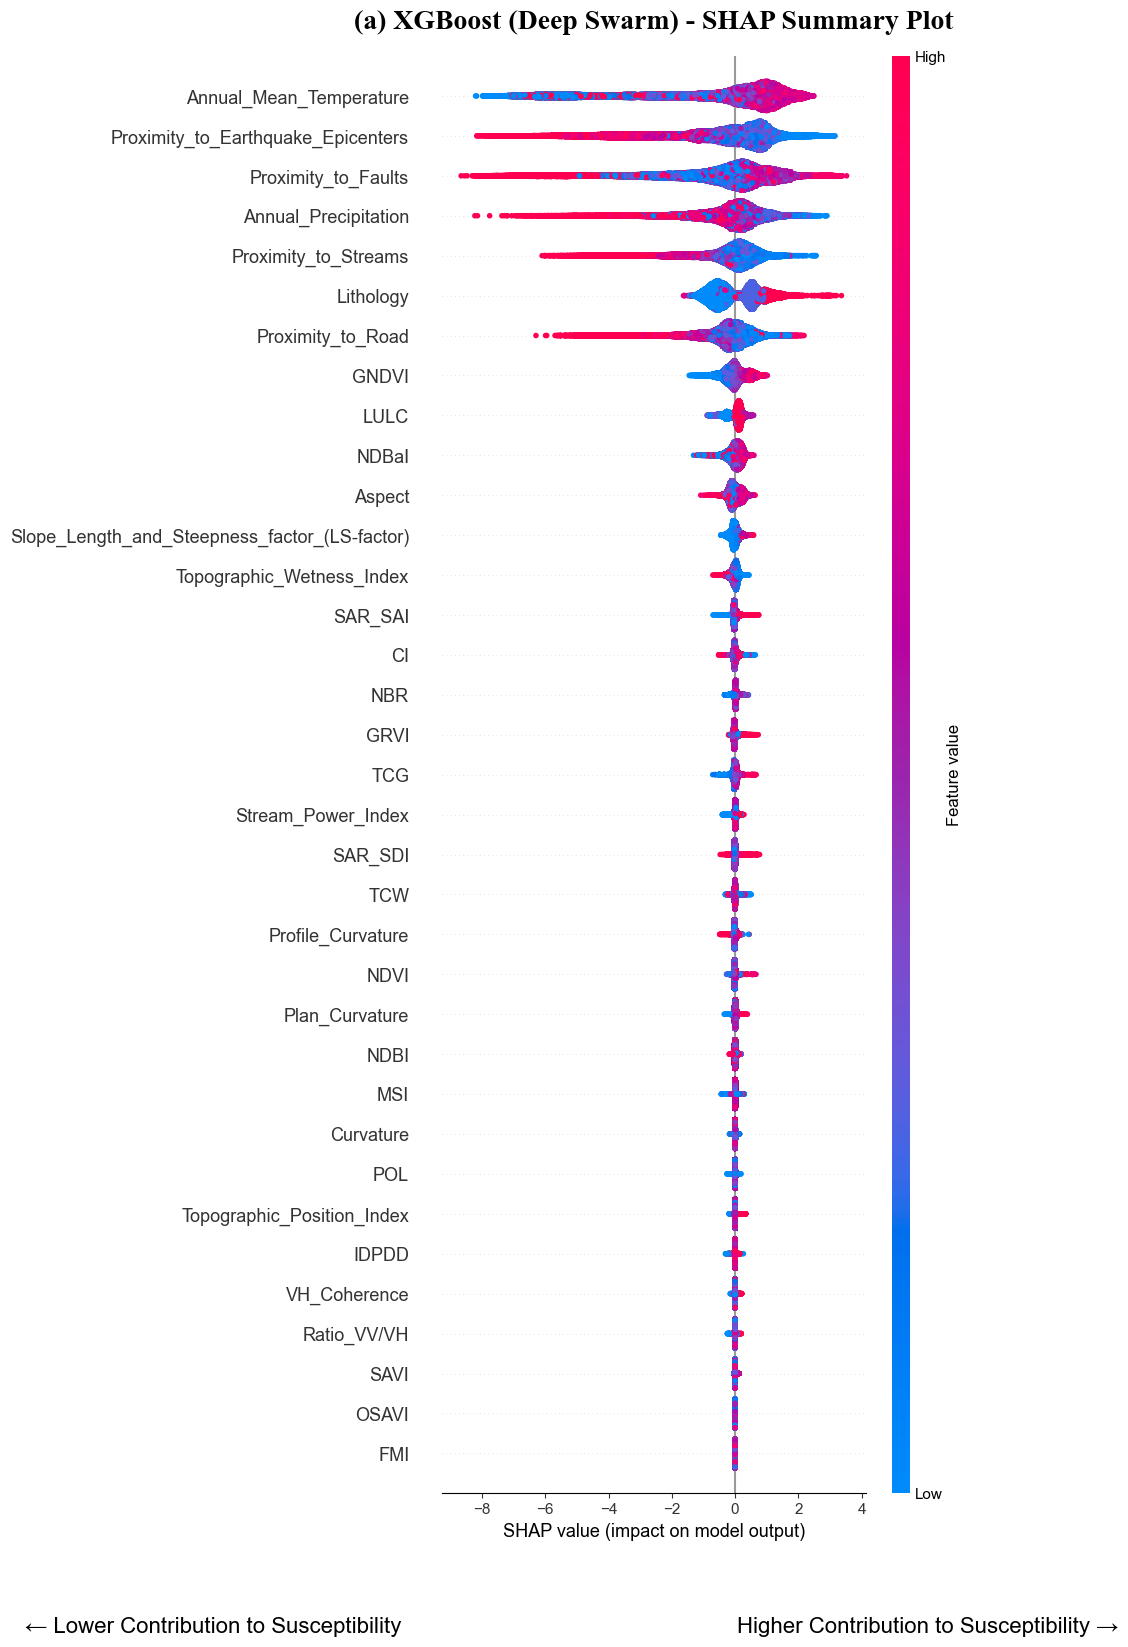

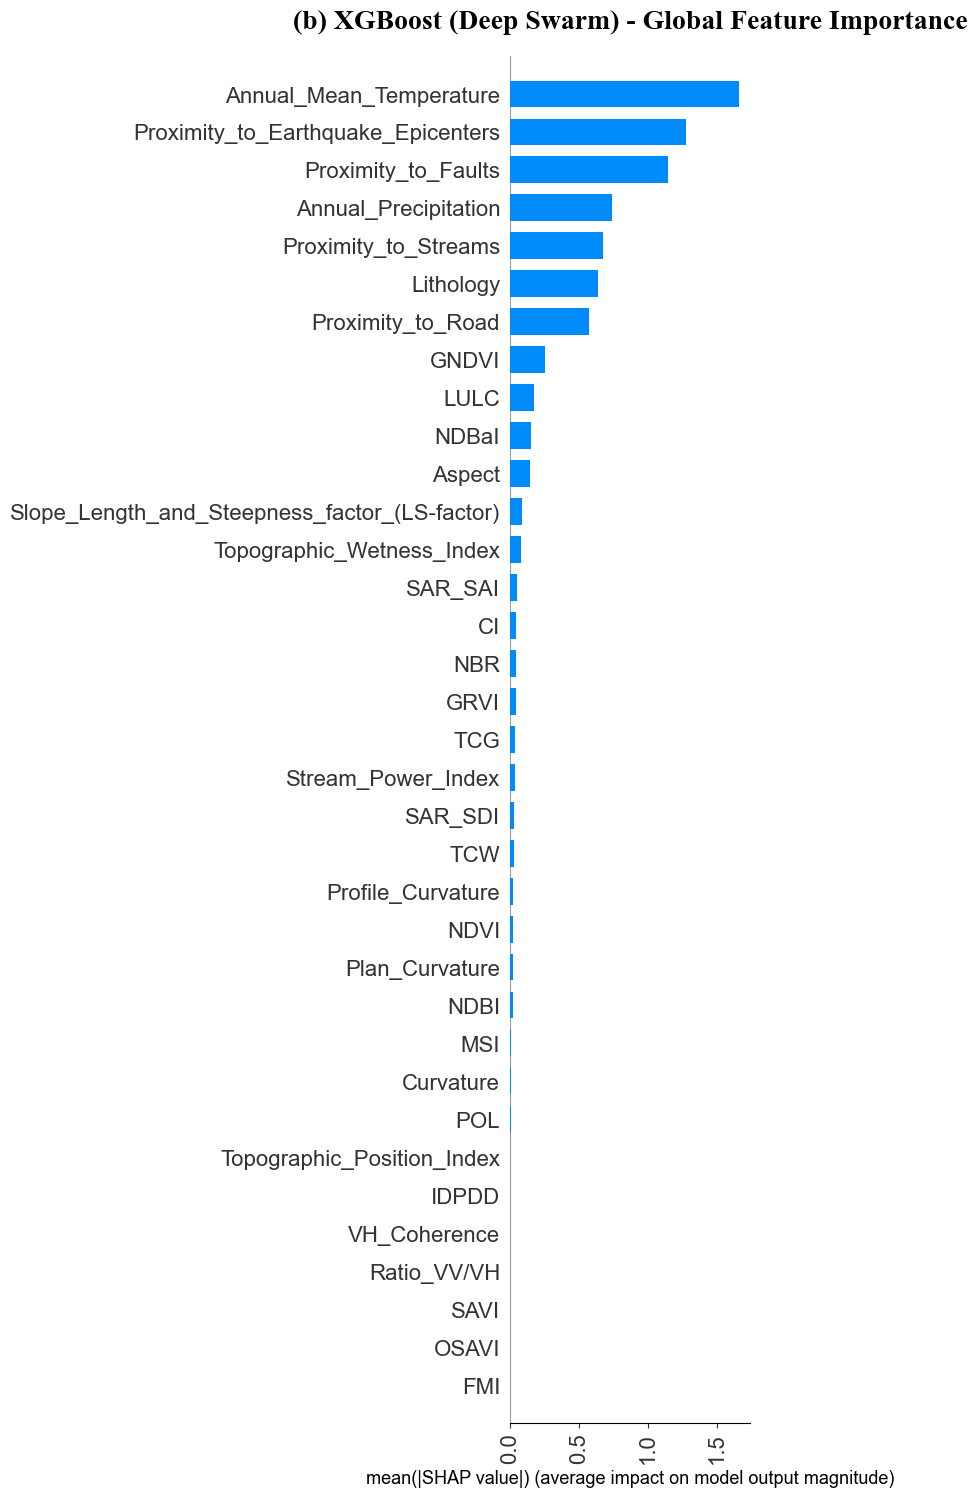

✅ All SHAP summary plots saved successfully.


In [58]:
import shap
import joblib
import matplotlib.pyplot as plt
import numpy as np
import os

# ----------- Configuration ------------
model_path = "models/DeepSwarm_XGBoost.pkl"
output_folder = "figures"
os.makedirs(output_folder, exist_ok=True)

font = {'family': 'Arial', 'size': 20}
plt.rc('font', **font)

# ----------- Load Model & Data ------------
model, selected_features = joblib.load(model_path)
X_selected = X_test[selected_features]

# ----------- Compute SHAP Values ------------
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_selected)

# ----------- Determine Format ------------
if isinstance(shap_values, list):
    # For classifier: list of arrays per class
    class_indices = [1] if len(shap_values) == 2 else list(range(len(shap_values)))
else:
    # For binary classification or regression: single array
    class_indices = [None]

# ----------- Plot Loop ------------
for class_idx in class_indices:
    shap_class = shap_values if class_idx is None else shap_values[class_idx]
    
    num_features = X_selected.shape[1]
    fig_height = max(6, 0.5 * num_features)


    # --- DOT PLOT ---
    fig = plt.figure(figsize=(18, fig_height))  # Wider and taller if needed
    
    # SHAP handles layout better if you don’t use tight_layout before or during plotting
    shap.summary_plot(
        shap_class,
        features=X_selected,
        plot_type="dot",
        feature_names=selected_features,
        show=False,
        max_display=num_features
    )
    
    # Now manually adjust spacing if needed
    plt.title(f"(a) XGBoost (Deep Swarm) - SHAP Summary Plot",
              fontsize=20, fontweight='bold', fontfamily='Times New Roman', pad=20)
    
    # You can try increasing fig height if you have many features:
    # fig.set_size_inches(18, 1.2 * num_features)
    
    plt.gcf().subplots_adjust(left=0.3)  # Makes space for long feature names
    plt.text(0.05, -4.5, 'Higher Contribution to Susceptibility \u2192', fontsize=16, fontweight='ultralight')
    plt.text(-22.43, -4.5, '\u2190 Lower Contribution to Susceptibility', fontsize=16, fontweight='ultralight')
    
    fig.savefig(f"{output_folder}/SHAP_summary_dot_DeepSwarmXGBoost.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # --- BAR PLOT ---
    fig = plt.figure(figsize=(18, fig_height))
    shap.summary_plot(
        shap_class,
        features=X_selected,
        plot_type="bar",
        feature_names=selected_features,
        show=False,
        max_display=num_features
    )
    plt.xticks(rotation=90, fontsize=16)
    plt.yticks(fontsize=16)
    plt.title(f"(b) XGBoost (Deep Swarm) - Global Feature Importance",
              fontsize=20, fontweight='bold', fontfamily='Times New Roman', pad=20)
    plt.tight_layout()
    fig.savefig(f"{output_folder}/SHAP_summary_bar_DeepSwarmXGBoost.png", dpi=300, bbox_inches='tight')
    plt.show()

print("✅ All SHAP summary plots saved successfully.")

In [59]:
# Calculate mean(|SHAP|) per feature
mean_abs_shap = np.abs(shap_values).mean(axis=0)
# Convert to percentage
percent_shap = 100 * mean_abs_shap / mean_abs_shap.sum()

# Create DataFrame
shap_percent_df = pd.DataFrame({
    'Feature': X_selected.columns,
    'SHAP_Importance_%': percent_shap
}).sort_values(by='SHAP_Importance_%', ascending=False)

# Show results
print(shap_percent_df)

# Optional: save
shap_percent_df.to_csv("results/shap_percentual_importance_XGBoost_DeepSwarm.csv", index=False)

                                          Feature  SHAP_Importance_%
31                        Annual_Mean_Temperature          20.671566
30             Proximity_to_Earthquake_Epicenters          15.931705
29                            Proximity_to_Faults          14.258739
32                           Annual_Precipitation           9.186112
28                           Proximity_to_Streams           8.423758
34                                      Lithology           7.946599
27                              Proximity_to_Road           7.126291
9                                           GNDVI           3.179407
33                                           LULC           2.204481
20                                          NDBaI           1.859498
0                                          Aspect           1.803751
7   Slope_Length_and_Steepness_factor_(LS-factor)           1.124370
4                       Topographic_Wetness_Index           1.008222
23                                

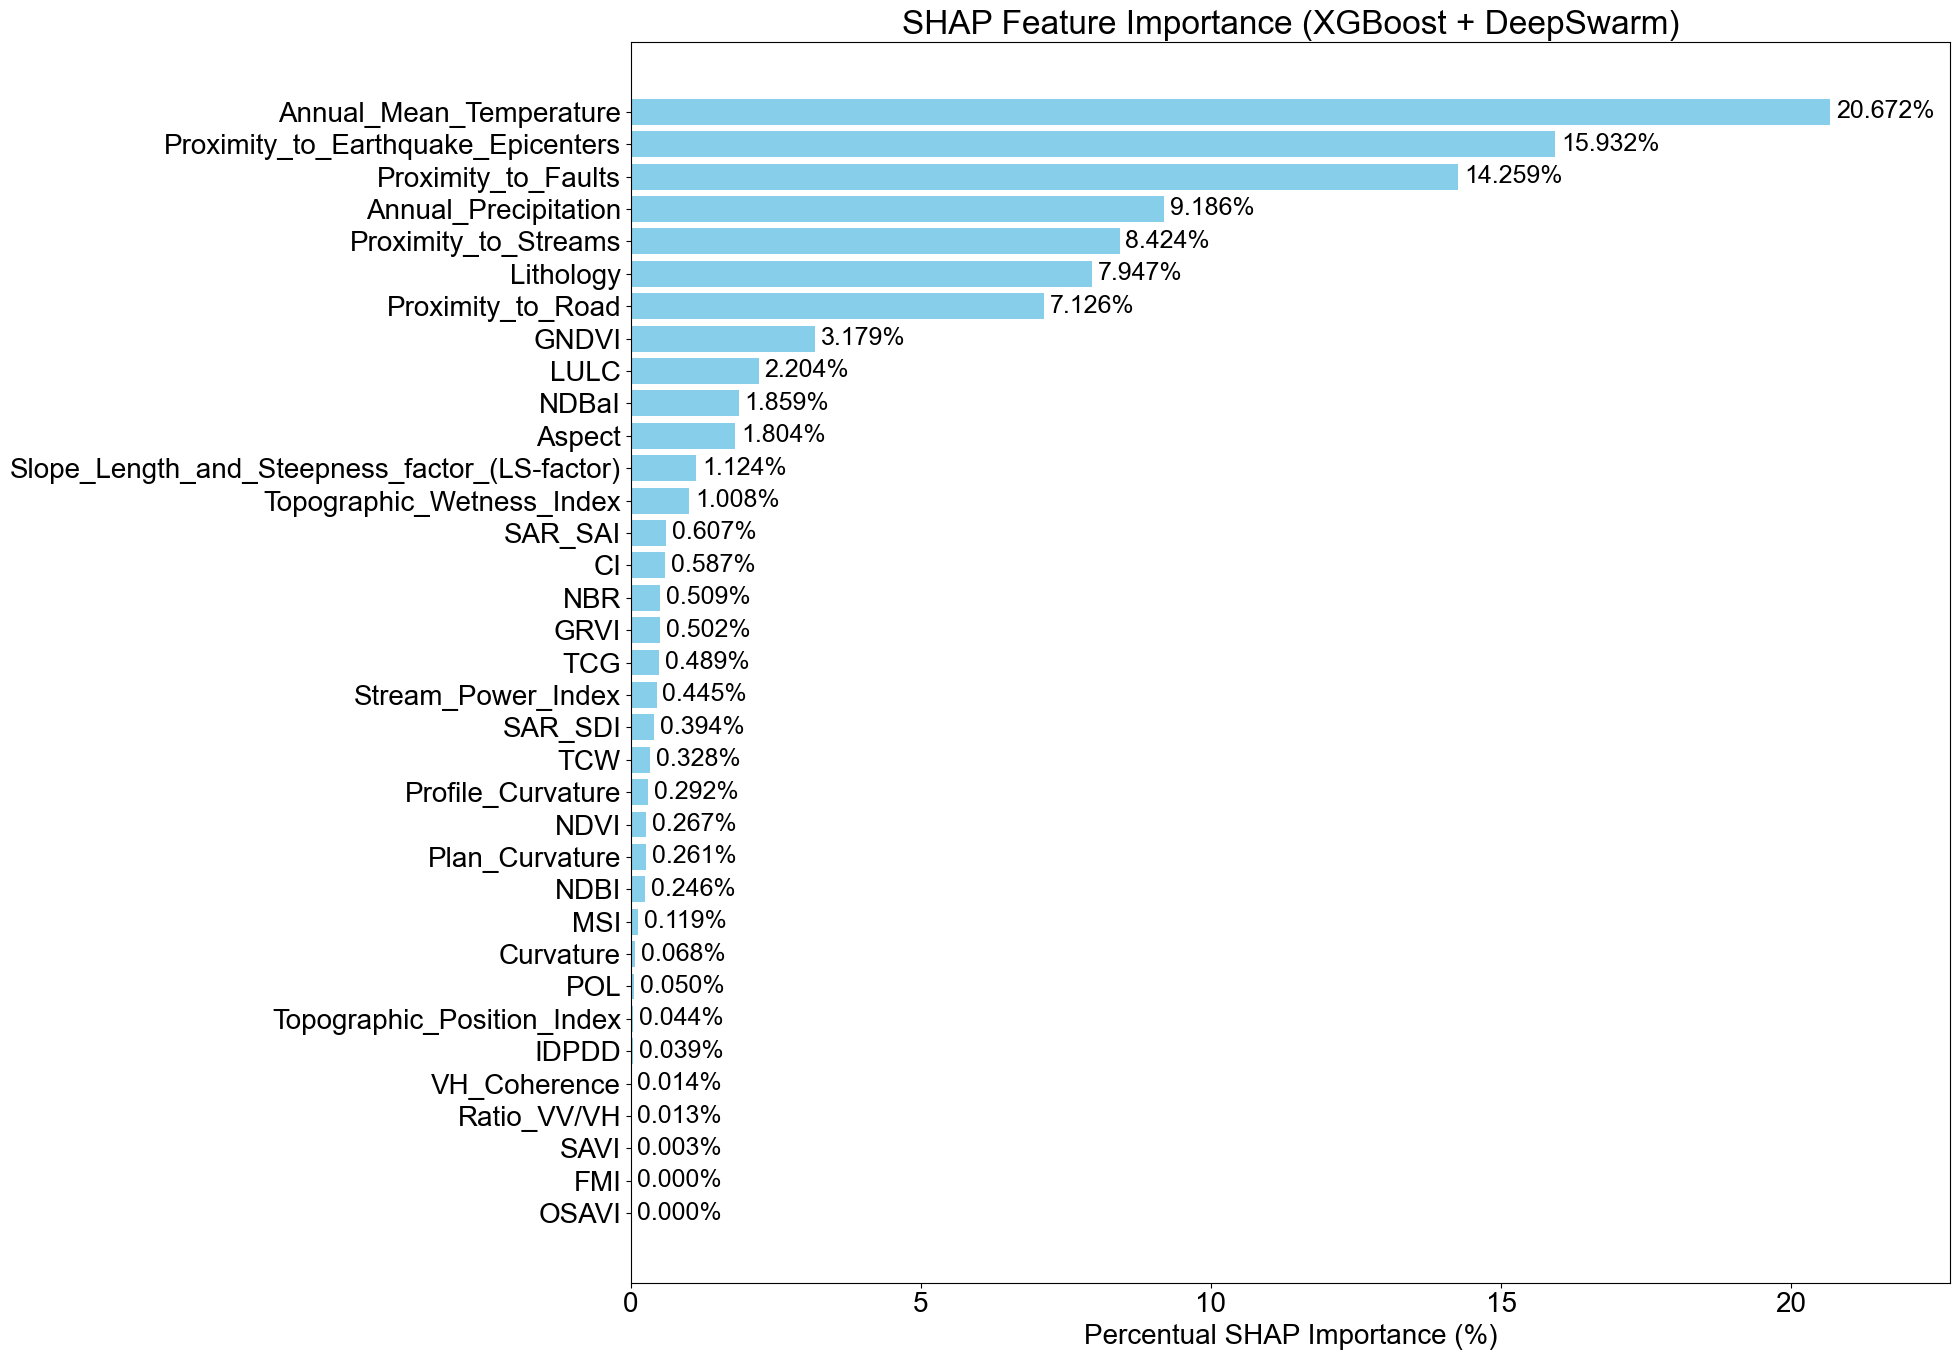

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 14))
bars = plt.barh(shap_percent_df['Feature'], shap_percent_df['SHAP_Importance_%'], color='skyblue')

# Add percentage text next to each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.1,
             bar.get_y() + bar.get_height() / 2,
             f"{width:.3f}%",
             va='center', ha='left', fontsize=18)

# Add padding to avoid overlap with figure edge
max_width = shap_percent_df['SHAP_Importance_%'].max()
plt.xlim(0, max_width * 1.1)

plt.xlabel("Percentual SHAP Importance (%)")
plt.title("SHAP Feature Importance (XGBoost + DeepSwarm)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("figures/SHAP_percentual_importance_bar_DeepSwarm_XGBoost.png")
plt.show()

In [61]:
total_percent = shap_percent_df["SHAP_Importance_%"].sum()
print(f"Total SHAP Percentage: {total_percent:.6f}%")

Total SHAP Percentage: 100.000008%


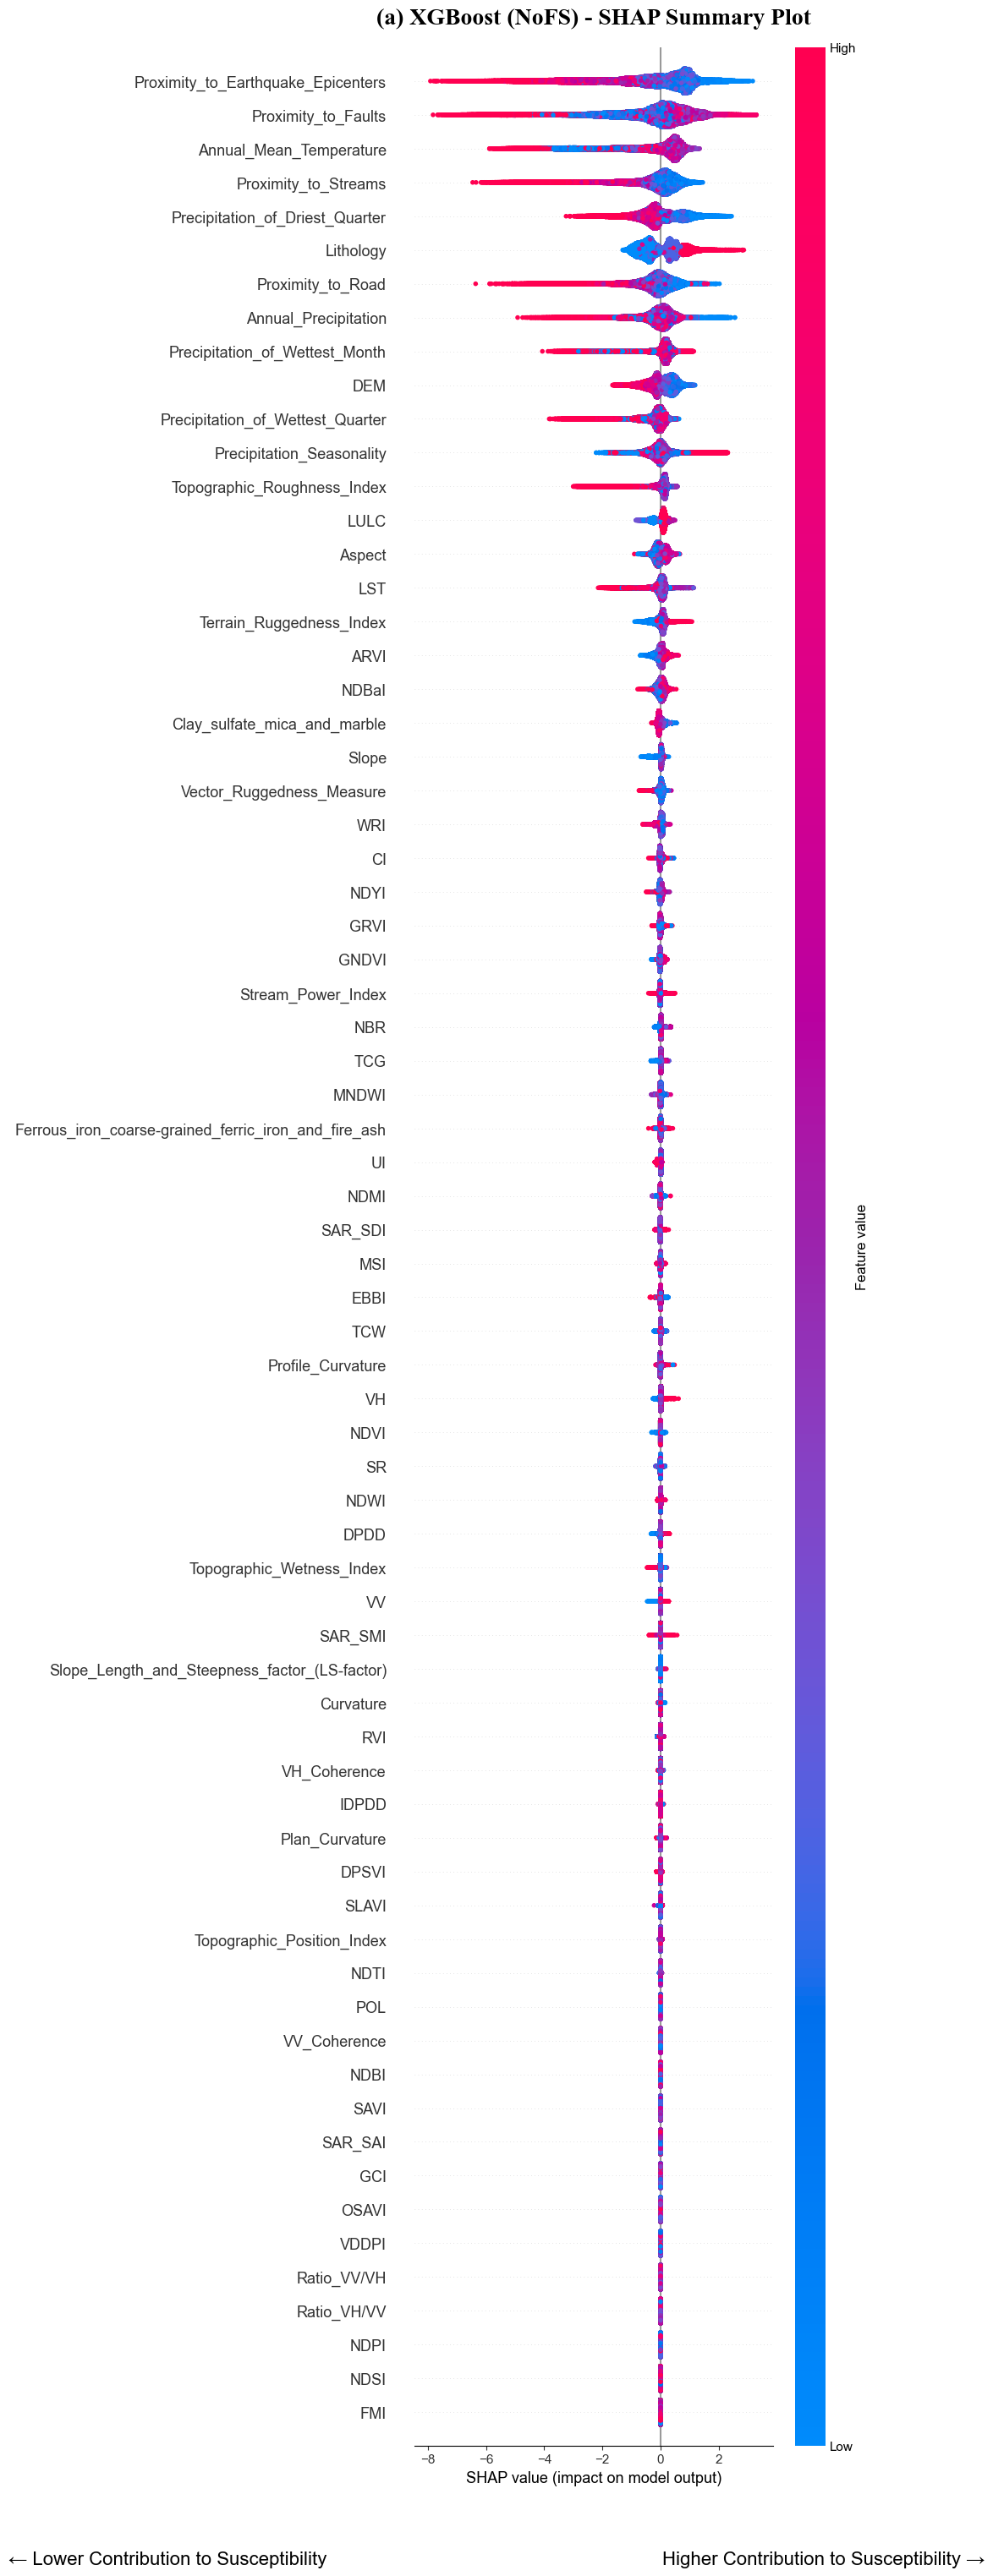

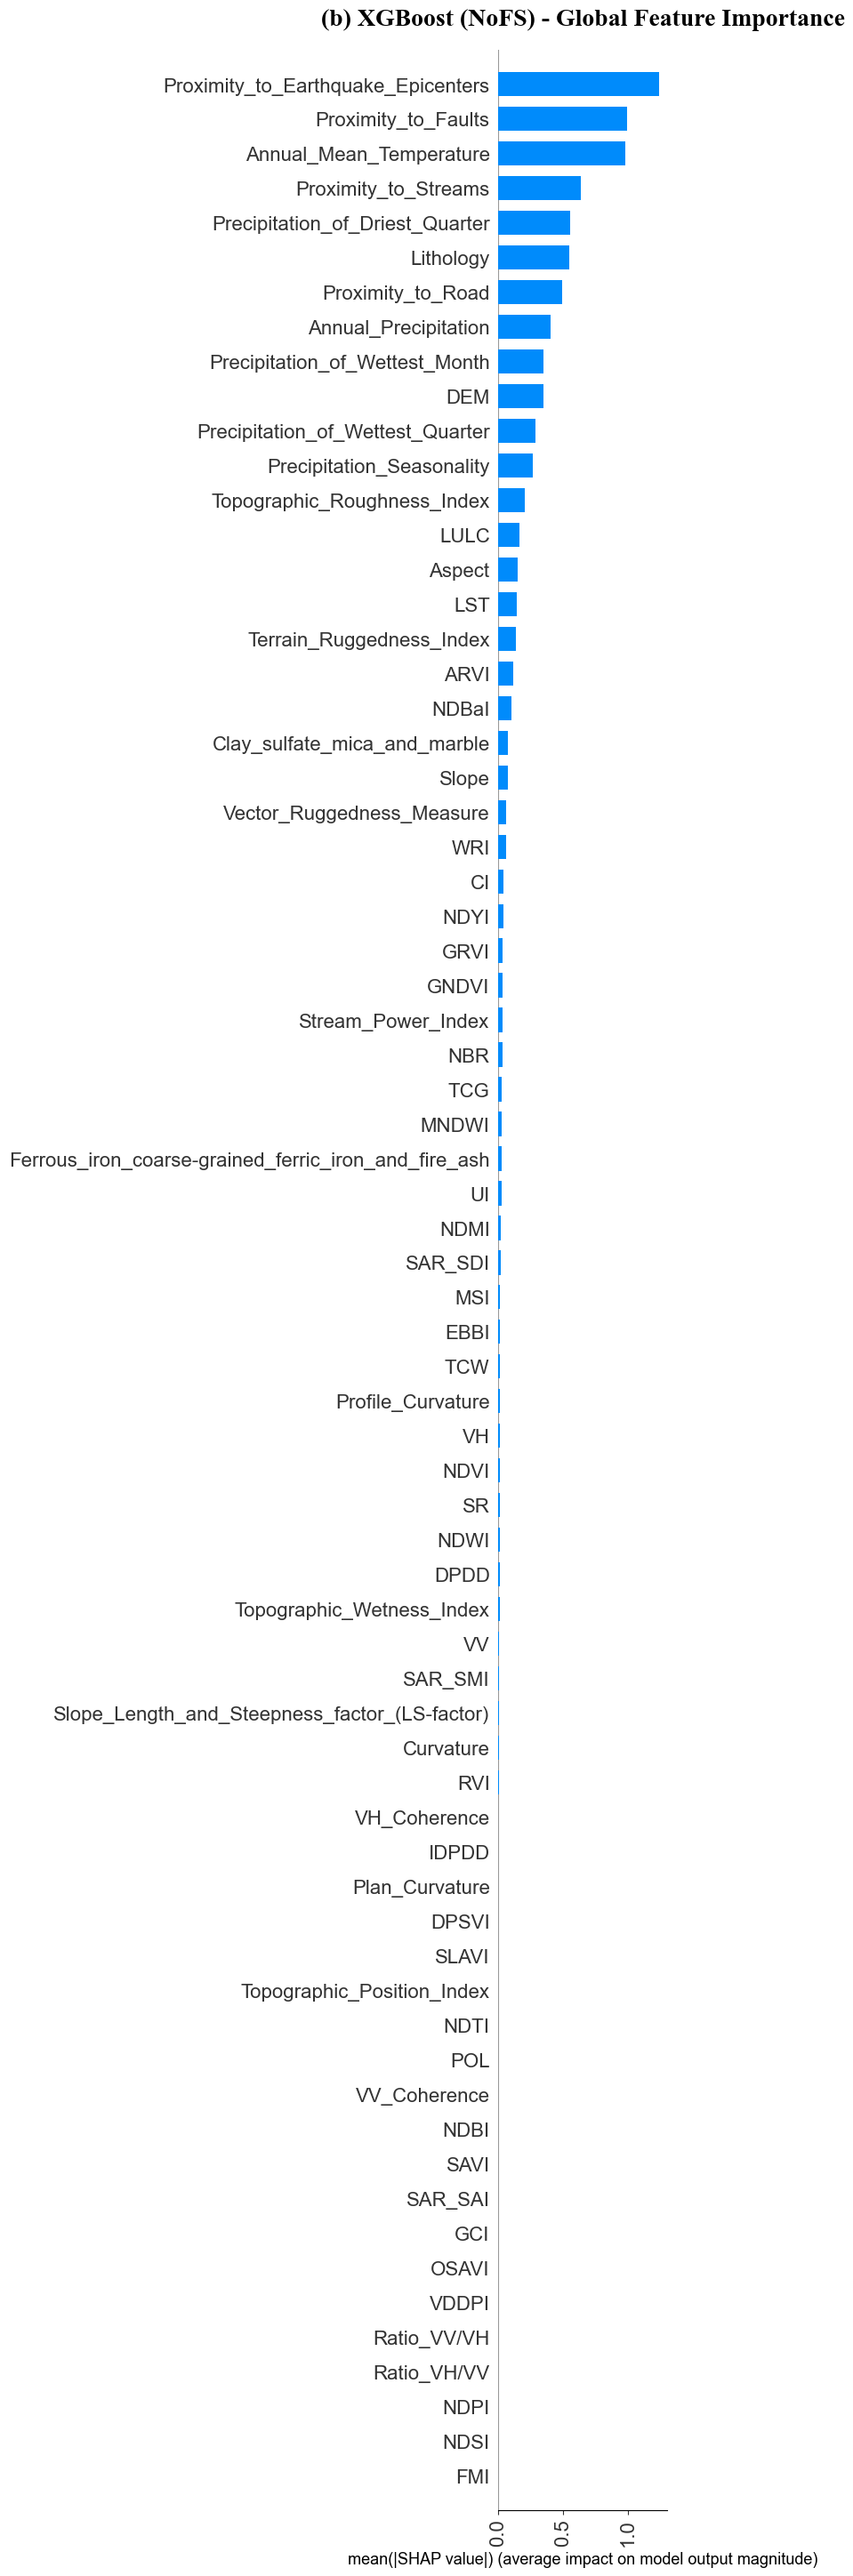

✅ All SHAP summary plots saved successfully.


In [62]:
import shap
import joblib
import matplotlib.pyplot as plt
import numpy as np
import os

# ----------- Configuration ------------
model_path = "models/No_FS_XGBoost.pkl"
output_folder = "figures"
os.makedirs(output_folder, exist_ok=True)

font = {'family': 'Arial', 'size': 20}
plt.rc('font', **font)

# ----------- Load Model & Data ------------
model, selected_features = joblib.load(model_path)
X_selected = X_test[selected_features]

# ----------- Compute SHAP Values ------------
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_selected)

# ----------- Determine Format ------------
if isinstance(shap_values, list):
    # For classifier: list of arrays per class
    class_indices = [1] if len(shap_values) == 2 else list(range(len(shap_values)))
else:
    # For binary classification or regression: single array
    class_indices = [None]

# ----------- Plot Loop ------------
for class_idx in class_indices:
    shap_class = shap_values if class_idx is None else shap_values[class_idx]
    
    num_features = X_selected.shape[1]
    fig_height = max(6, 0.5 * num_features)


    # --- DOT PLOT ---
    fig = plt.figure(figsize=(18, fig_height))  # Wider and taller if needed
    
    # SHAP handles layout better if you don’t use tight_layout before or during plotting
    shap.summary_plot(
        shap_class,
        features=X_selected,
        plot_type="dot",
        feature_names=selected_features,
        show=False,
        max_display=num_features
    )
    
    # Now manually adjust spacing if needed
    plt.title(f"(a) XGBoost (NoFS) - SHAP Summary Plot",
              fontsize=20, fontweight='bold', fontfamily='Times New Roman', pad=20)
    
    # You can try increasing fig height if you have many features:
    # fig.set_size_inches(18, 1.2 * num_features)
    
    plt.gcf().subplots_adjust(left=0.3)  # Makes space for long feature names
    plt.text(0.05, -4.5, 'Higher Contribution to Susceptibility \u2192', fontsize=16, fontweight='ultralight')
    plt.text(-22.43, -4.5, '\u2190 Lower Contribution to Susceptibility', fontsize=16, fontweight='ultralight')
    
    fig.savefig(f"{output_folder}/SHAP_summary_dot_NoFS_XGBoost", dpi=300, bbox_inches='tight')
    plt.show()
    
    # --- BAR PLOT ---
    fig = plt.figure(figsize=(18, fig_height))
    shap.summary_plot(
        shap_class,
        features=X_selected,
        plot_type="bar",
        feature_names=selected_features,
        show=False,
        max_display=num_features
    )
    plt.xticks(rotation=90, fontsize=16)
    plt.yticks(fontsize=16)
    plt.title(f"(b) XGBoost (NoFS) - Global Feature Importance",
              fontsize=20, fontweight='bold', fontfamily='Times New Roman', pad=20)
    plt.tight_layout()
    fig.savefig(f"{output_folder}/SHAP_summary_bar_NoFS_XGBoost.png", dpi=300, bbox_inches='tight')
    plt.show()

print("✅ All SHAP summary plots saved successfully.")

In [63]:
# Calculate mean(|SHAP|) per feature
mean_abs_shap = np.abs(shap_values).mean(axis=0)
# Convert to percentage
percent_shap = 100 * mean_abs_shap / mean_abs_shap.sum()

# Create DataFrame
shap_percent_df = pd.DataFrame({
    'Feature': X_selected.columns,
    'SHAP_Importance_%': percent_shap
}).sort_values(by='SHAP_Importance_%', ascending=False)

# Show results
print(shap_percent_df)

# Optional: save
shap_percent_df.to_csv("results/shap_percentual_importance_XGBoost_NoFS.csv", index=False)

                               Feature  SHAP_Importance_%
61  Proximity_to_Earthquake_Epicenters          14.041675
60                 Proximity_to_Faults          11.215111
62             Annual_Mean_Temperature          11.088825
59                Proximity_to_Streams           7.198556
67     Precipitation_of_Driest_Quarter           6.303046
..                                 ...                ...
42                                NDSI           0.000000
52                             SAR_SAI           0.000000
31                                NDBI           0.000000
48                               VDDPI           0.000000
29                                 FMI           0.000000

[70 rows x 2 columns]


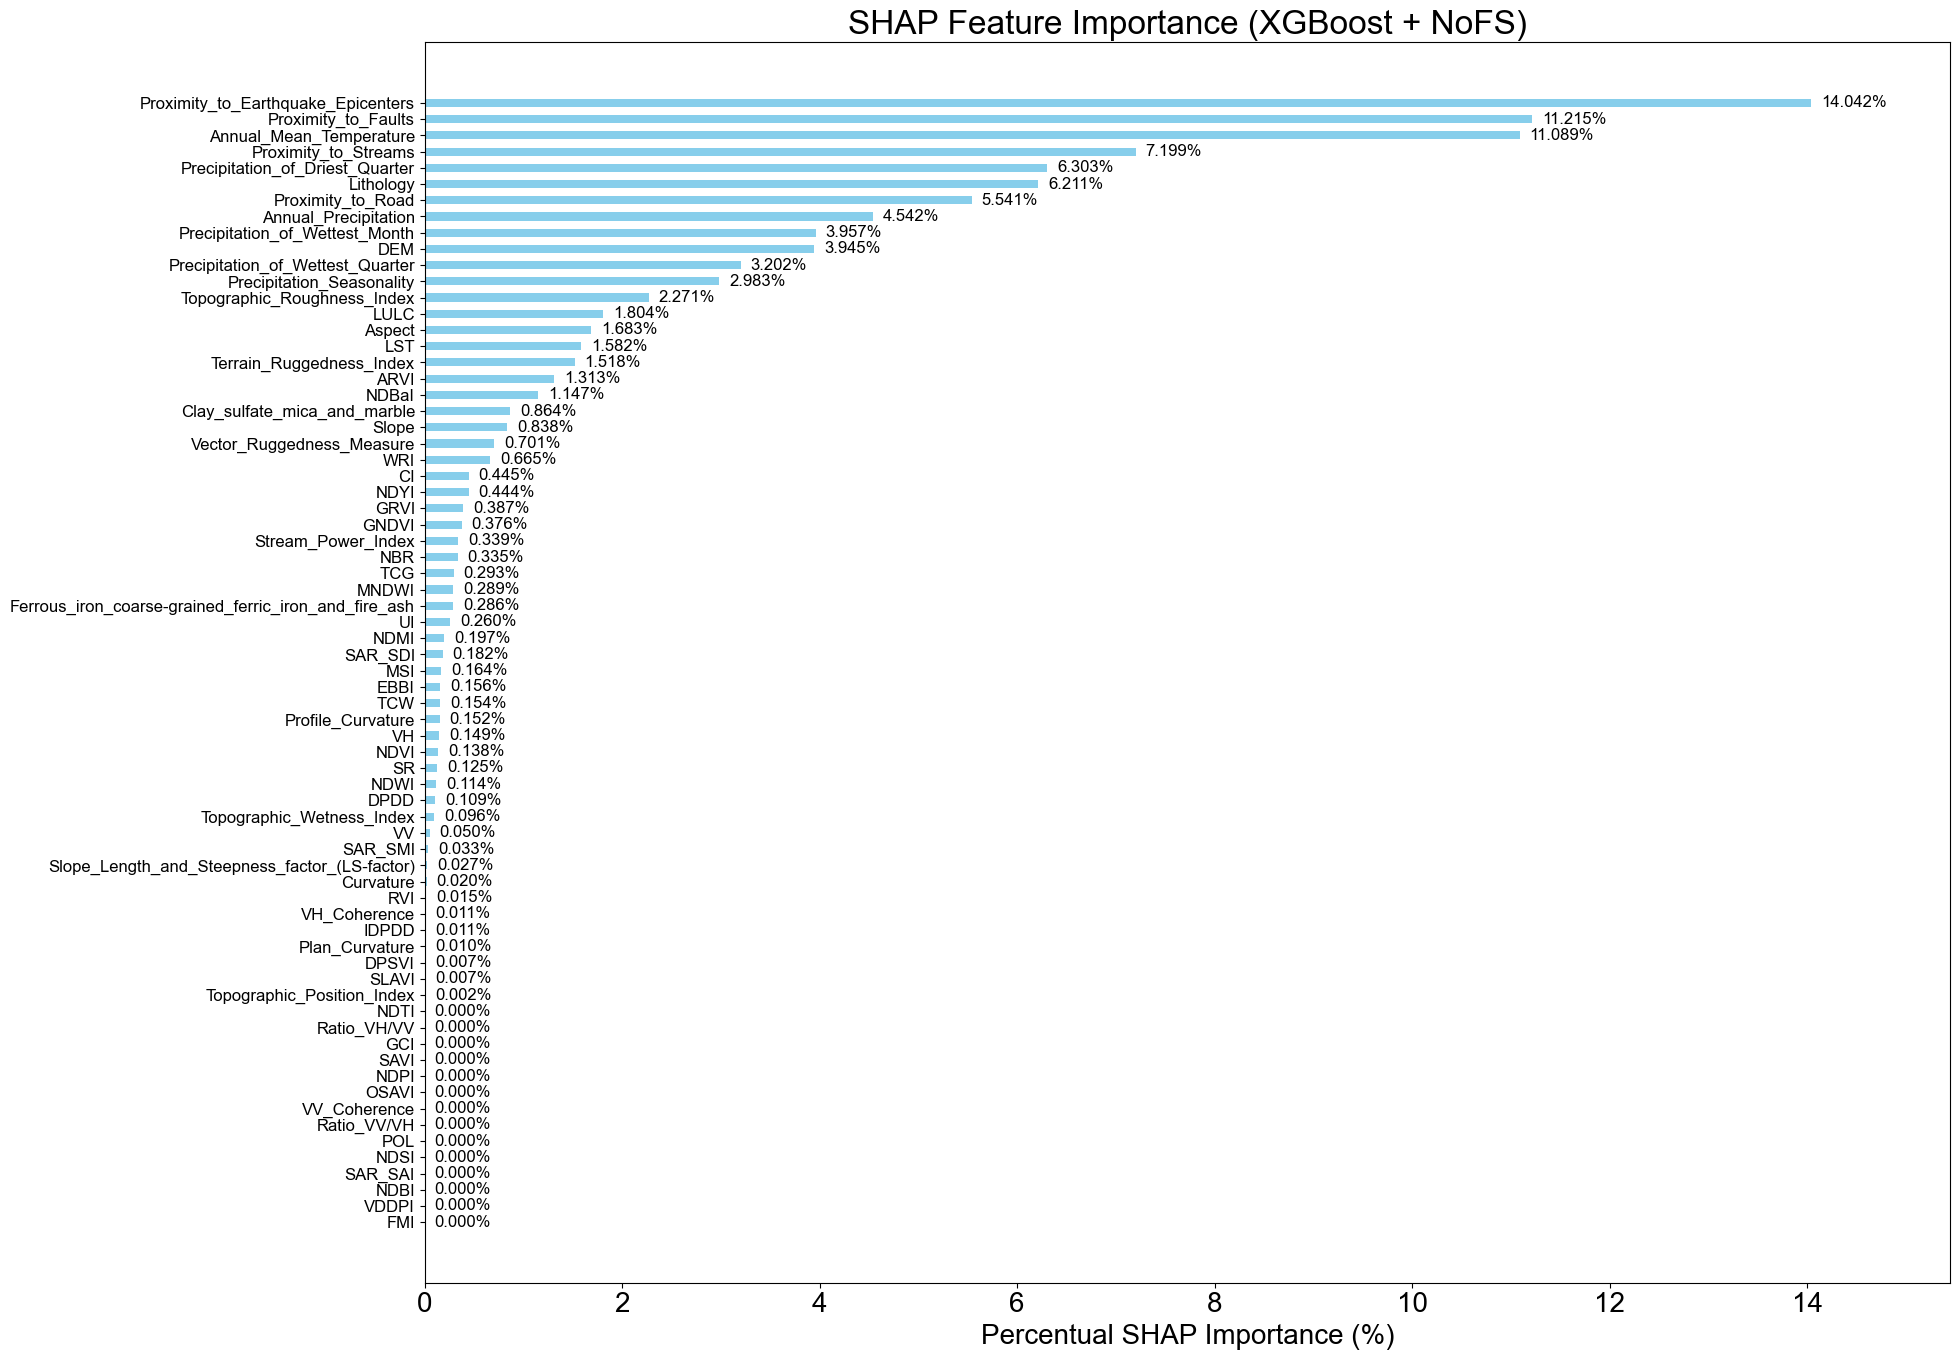

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 14))
bar_height = 0.5
bars = plt.barh(shap_percent_df['Feature'], shap_percent_df['SHAP_Importance_%'], color='skyblue', height=bar_height)

# Add percentage text next to each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.1,
             bar.get_y() + bar.get_height() / 2, # Use bar.get_height() here
             f"{width:.3f}%",
             va='center', ha='left', fontsize=12)
plt.tick_params(axis='y', labelsize=12)
# Add padding to avoid overlap with figure edge
max_width = shap_percent_df['SHAP_Importance_%'].max()
plt.xlim(0, max_width * 1.1)

plt.xlabel("Percentual SHAP Importance (%)")
plt.title("SHAP Feature Importance (XGBoost + NoFS)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("figures/SHAP_percentual_importance_bar_XGBoost_NoFS.png")
plt.show()

In [65]:
total_percent = shap_percent_df["SHAP_Importance_%"].sum()
print(f"Total SHAP Percentage: {total_percent:.6f}%")

Total SHAP Percentage: 100.000000%


In [66]:
import joblib
import numpy as np
import pandas as pd
from statsmodels.stats.contingency_tables import mcnemar

# List of your model files
model_files = [
    "models/No_FS_XGBoost.pkl",
    "models/No_FS_CatBoost.pkl",
    "models/No_FS_LightGBM.pkl",
    "models/SHAP_RFE_XGBoost.pkl",
    "models/SHAP_RFE_CatBoost.pkl",
    "models/SHAP_RFE_LightGBM.pkl",
    "models/DeepSwarm_XGBoost.pkl",
    "models/DeepSwarm_CatBoost.pkl",
    "models/DeepSwarm_LightGBM.pkl",
]

# Load models and generate predictions
predictions = {}
for path in model_files:
    model, features = joblib.load(path)
    X_test_sel = X_test[features]
    y_pred = model.predict(X_test_sel)
    predictions[path] = y_pred

# McNemar test helper function
def run_mcnemar(y_true, y_pred1, y_pred2):
    # Build contingency table: [ [both correct, model1 wrong only],
    #                            [model2 wrong only, both wrong] ]
    contingency = np.zeros((2, 2), dtype=int)
    for yt, p1, p2 in zip(y_true, y_pred1, y_pred2):
        correct1 = (p1 == yt)
        correct2 = (p2 == yt)
        contingency[int(correct1), int(correct2)] += 1

    result = mcnemar(contingency, exact=True)
    return result.statistic, result.pvalue

# Run pairwise McNemar tests and collect results
results = []
for i, path1 in enumerate(model_files):
    for j, path2 in enumerate(model_files):
        if j <= i:
            continue
        stat, p = run_mcnemar(y_test.values, predictions[path1], predictions[path2])
        results.append({
            "Model 1": path1.split("/")[-1].replace(".pkl", ""),
            "Model 2": path2.split("/")[-1].replace(".pkl", ""),
            "McNemar Statistic": stat,
            "p-value": p,
            "Significant (p < 0.05)": p < 0.05
        })

# Display results as a DataFrame
df_results = pd.DataFrame(results)
print(df_results)

# Optionally save to CSV for later review
df_results.to_csv("results/mcnemar_results.csv", index=False)


               Model 1             Model 2  McNemar Statistic        p-value  \
0        No_FS_XGBoost      No_FS_CatBoost              454.0   0.000000e+00   
1        No_FS_XGBoost      No_FS_LightGBM              324.0   0.000000e+00   
2        No_FS_XGBoost    SHAP_RFE_XGBoost              758.0   3.405543e-04   
3        No_FS_XGBoost   SHAP_RFE_CatBoost              491.0  1.480187e-292   
4        No_FS_XGBoost   SHAP_RFE_LightGBM              345.0   0.000000e+00   
5        No_FS_XGBoost   DeepSwarm_XGBoost              957.0   1.805444e-11   
6        No_FS_XGBoost  DeepSwarm_CatBoost              522.0   0.000000e+00   
7        No_FS_XGBoost  DeepSwarm_LightGBM              435.0   0.000000e+00   
8       No_FS_CatBoost      No_FS_LightGBM              760.0  2.322656e-187   
9       No_FS_CatBoost    SHAP_RFE_XGBoost              393.0   0.000000e+00   
10      No_FS_CatBoost   SHAP_RFE_CatBoost              449.0   5.363030e-12   
11      No_FS_CatBoost   SHAP_RFE_LightG

In [67]:
def interpret_mcnemar_results(df, alpha=0.05):
    critical_value = 3.84  # chi-square critical value for df=1, alpha=0.05

    total_tests = len(df)
    significant_stat = (df['McNemar Statistic'] > critical_value).sum()
    nonsignificant_stat = total_tests - significant_stat

    significant_pval = (df['p-value'] < alpha).sum()
    nonsignificant_pval = total_tests - significant_pval

    print(f"Total pairwise comparisons: {total_tests}\n")

    print(f"Using McNemar statistic > {critical_value} as criterion:")
    print(f"  Significantly different pairs: {significant_stat}")
    print(f"  Not significantly different pairs: {nonsignificant_stat}\n")

    print(f"Using p-value < {alpha} as criterion:")
    print(f"  Significantly different pairs: {significant_pval}")
    print(f"  Not significantly different pairs: {nonsignificant_pval}\n")

    print("Interpretation:")
    print("- McNemar test checks if two classifiers differ significantly in their predictions.")
    print(f"- If McNemar statistic > {critical_value} or p-value < {alpha}, the difference is statistically significant.")
    print("- Otherwise, classifiers are considered statistically similar on the test data.\n")

    if nonsignificant_stat == 0 and nonsignificant_pval == 0:
        print("=> All model pairs show statistically significant differences.")
    else:
        print("=> Some model pairs do not differ significantly.\n")

    # Optionally, print top 5 significant and nonsignificant pairs for insight
    print("Top 5 significant pairs (lowest p-values):")
    print(df[df['p-value'] < alpha].sort_values('p-value').head(5)[
        ['Model 1', 'Model 2', 'McNemar Statistic', 'p-value']])

    print("\nTop 5 nonsignificant pairs (highest p-values):")
    print(df[df['p-value'] >= alpha].sort_values('p-value', ascending=False).head(5)[
        ['Model 1', 'Model 2', 'McNemar Statistic', 'p-value']])
interpret_mcnemar_results(df_results)

Total pairwise comparisons: 36

Using McNemar statistic > 3.84 as criterion:
  Significantly different pairs: 36
  Not significantly different pairs: 0

Using p-value < 0.05 as criterion:
  Significantly different pairs: 36
  Not significantly different pairs: 0

Interpretation:
- McNemar test checks if two classifiers differ significantly in their predictions.
- If McNemar statistic > 3.84 or p-value < 0.05, the difference is statistically significant.
- Otherwise, classifiers are considered statistically similar on the test data.

=> All model pairs show statistically significant differences.
Top 5 significant pairs (lowest p-values):
              Model 1             Model 2  McNemar Statistic  p-value
0       No_FS_XGBoost      No_FS_CatBoost              454.0      0.0
24   SHAP_RFE_XGBoost  DeepSwarm_CatBoost              422.0      0.0
25   SHAP_RFE_XGBoost  DeepSwarm_LightGBM              384.0      0.0
18     No_FS_LightGBM   DeepSwarm_XGBoost              618.0      0.0
34  D